In [1]:
### install/upgrade libraries
!pip install lazypredict

In [2]:
!pip show "xgboost"

Name: xgboost
Version: 1.6.2
Summary: XGBoost Python Package
Home-page: https://github.com/dmlc/xgboost
Author: 
Author-email: 
License: Apache-2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: numpy, scipy
Required-by: lazypredict, TPOT


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/students-adaptability-level-in-online-education/students_adaptability_level_online_education.csv


In [4]:
### import libraries

### base libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### data preprocessing
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

### models and pipelines
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTEN, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK


### model evaluations
from sklearn.metrics import f1_score, classification_report, roc_curve, ConfusionMatrixDisplay, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

### model interpretation
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap


### ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Students Adaptability Classification

## Import Data

In [5]:
data = pd.read_csv("/kaggle/input/students-adaptability-level-in-online-education/students_adaptability_level_online_education.csv")
data.head()

Gender    Age Education Level Institution Type IT Student Location  \
0    Boy  21-25      University   Non Government         No      Yes   
1   Girl  21-25      University   Non Government         No      Yes   
2   Girl  16-20         College       Government         No      Yes   
3   Girl  11-15          School   Non Government         No      Yes   
4   Girl  16-20          School   Non Government         No      Yes   

  Load-shedding Financial Condition Internet Type Network Type Class Duration  \
0           Low                 Mid          Wifi           4G            3-6   
1          High                 Mid   Mobile Data           4G            1-3   
2           Low                 Mid          Wifi           4G            1-3   
3           Low                 Mid   Mobile Data           4G            1-3   
4           Low                Poor   Mobile Data           3G              0   

  Self Lms  Device Adaptivity Level  
0       No     Tab         Moderate  
1      Yes  Mobile         Moderate  
2       No  Mobile         Moderate  
3       No  Mobile         Moderate  
4       No  Mobile              Low

In [6]:
target = "Adaptivity Level"

## EDA

In [7]:
### EDA
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Gender               1205 non-null   object
 1   Age                  1205 non-null   object
 2   Education Level      1205 non-null   object
 3   Institution Type     1205 non-null   object
 4   IT Student           1205 non-null   object
 5   Location             1205 non-null   object
 6   Load-shedding        1205 non-null   object
 7   Financial Condition  1205 non-null   object
 8   Internet Type        1205 non-null   object
 9   Network Type         1205 non-null   object
 10  Class Duration       1205 non-null   object
 11  Self Lms             1205 non-null   object
 12  Device               1205 non-null   object
 13  Adaptivity Level     1205 non-null   object
dtypes: object(14)
memory usage: 131.9+ KB


### check duplicated data

In [8]:
data[~data.duplicated()]

Gender    Age Education Level Institution Type IT Student Location  \
0       Boy  21-25      University   Non Government         No      Yes   
1      Girl  21-25      University   Non Government         No      Yes   
2      Girl  16-20         College       Government         No      Yes   
3      Girl  11-15          School   Non Government         No      Yes   
4      Girl  16-20          School   Non Government         No      Yes   
...     ...    ...             ...              ...        ...      ...   
1124    Boy  21-25      University   Non Government        Yes       No   
1132    Boy  16-20         College       Government         No      Yes   
1149   Girl  16-20         College   Non Government         No       No   
1160    Boy  21-25      University   Non Government        Yes       No   
1197    Boy  21-25      University   Non Government        Yes      Yes   

     Load-shedding Financial Condition Internet Type Network Type  \
0              Low                 Mid          Wifi           4G   
1             High                 Mid   Mobile Data           4G   
2              Low                 Mid          Wifi           4G   
3              Low                 Mid   Mobile Data           4G   
4              Low                Poor   Mobile Data           3G   
...            ...                 ...           ...          ...   
1124          High                 Mid   Mobile Data           3G   
1132           Low                 Mid   Mobile Data           3G   
1149           Low                 Mid   Mobile Data           3G   
1160          High                 Mid   Mobile Data           3G   
1197           Low                 Mid   Mobile Data           4G   

     Class Duration Self Lms    Device Adaptivity Level  
0               3-6       No       Tab         Moderate  
1               1-3      Yes    Mobile         Moderate  
2               1-3       No    Mobile         Moderate  
3               1-3       No    Mobile         Moderate  
4                 0       No    Mobile              Low  
...             ...      ...       ...              ...  
1124            3-6       No  Computer              Low  
1132            1-3       No    Mobile         Moderate  
1149            1-3      Yes    Mobile              Low  
1160            1-3      Yes    Mobile         Moderate  
1197            3-6       No  Computer         Moderate  

[256 rows x 14 columns]

Too many duplicated data! Since our data are output of survey, there can be samples with same values. But we should be wary about data contamination(identical samples on both train / test subset), which can lead us to overfitted model.

In [9]:
data.describe()

Gender    Age Education Level Institution Type IT Student Location  \
count    1205   1205            1205             1205       1205     1205   
unique      2      6               3                2          2        2   
top       Boy  21-25          School   Non Government         No      Yes   
freq      663    374             530              823        901      935   

       Load-shedding Financial Condition Internet Type Network Type  \
count           1205                1205          1205         1205   
unique             2                   3             2            3   
top              Low                 Mid   Mobile Data           4G   
freq            1004                 878           695          775   

       Class Duration Self Lms  Device Adaptivity Level  
count            1205     1205    1205             1205  
unique              3        2       3                3  
top               1-3       No  Mobile         Moderate  
freq              840      995    1013              625

In [10]:
for i in data.columns:
    print(i, ":", data[i].unique().tolist())

Gender : ['Boy', 'Girl']
Age : ['21-25', '16-20', '11-15', '26-30', '6-10', '1-5']
Education Level : ['University', 'College', 'School']
Institution Type : ['Non Government', 'Government']
IT Student : ['No', 'Yes']
Location : ['Yes', 'No']
Load-shedding : ['Low', 'High']
Financial Condition : ['Mid', 'Poor', 'Rich']
Internet Type : ['Wifi', 'Mobile Data']
Network Type : ['4G', '3G', '2G']
Class Duration : ['3-6', '1-3', '0']
Self Lms : ['No', 'Yes']
Device : ['Tab', 'Mobile', 'Computer']
Adaptivity Level : ['Moderate', 'Low', 'High']


In [11]:
plt.style.use("ggplot")
plt.rcParams["figure.dpi"] = 200

### Make order list for further ordinal encoding and plotting graph

In [12]:
order = {}
for key in data.columns:
    order[key] = data[key].unique().tolist()

for key, values in order.items():
    if "Yes" in values:
        order[key] = ["No", "Yes"]

order["Age"] = ["1-5", "6-10", "11-15", "16-20", "21-25", "26-30"]
order["Education Level"] = ["School", "College", "University"]
order["Financial Condition"] = ["Poor", "Mid", "Rich"]
order["Network Type"] = ["2G", "3G", "4G"]
order["Class Duration"] = ["0", "1-3", "3-6"]
order["Adaptivity Level"] = ['Low', 'Moderate', 'High']

In [13]:
order

{'Gender': ['Boy', 'Girl'],
 'Age': ['1-5', '6-10', '11-15', '16-20', '21-25', '26-30'],
 'Education Level': ['School', 'College', 'University'],
 'Institution Type': ['Non Government', 'Government'],
 'IT Student': ['No', 'Yes'],
 'Location': ['No', 'Yes'],
 'Load-shedding': ['Low', 'High'],
 'Financial Condition': ['Poor', 'Mid', 'Rich'],
 'Internet Type': ['Wifi', 'Mobile Data'],
 'Network Type': ['2G', '3G', '4G'],
 'Class Duration': ['0', '1-3', '3-6'],
 'Self Lms': ['No', 'Yes'],
 'Device': ['Tab', 'Mobile', 'Computer'],
 'Adaptivity Level': ['Low', 'Moderate', 'High']}

### Features Distribution

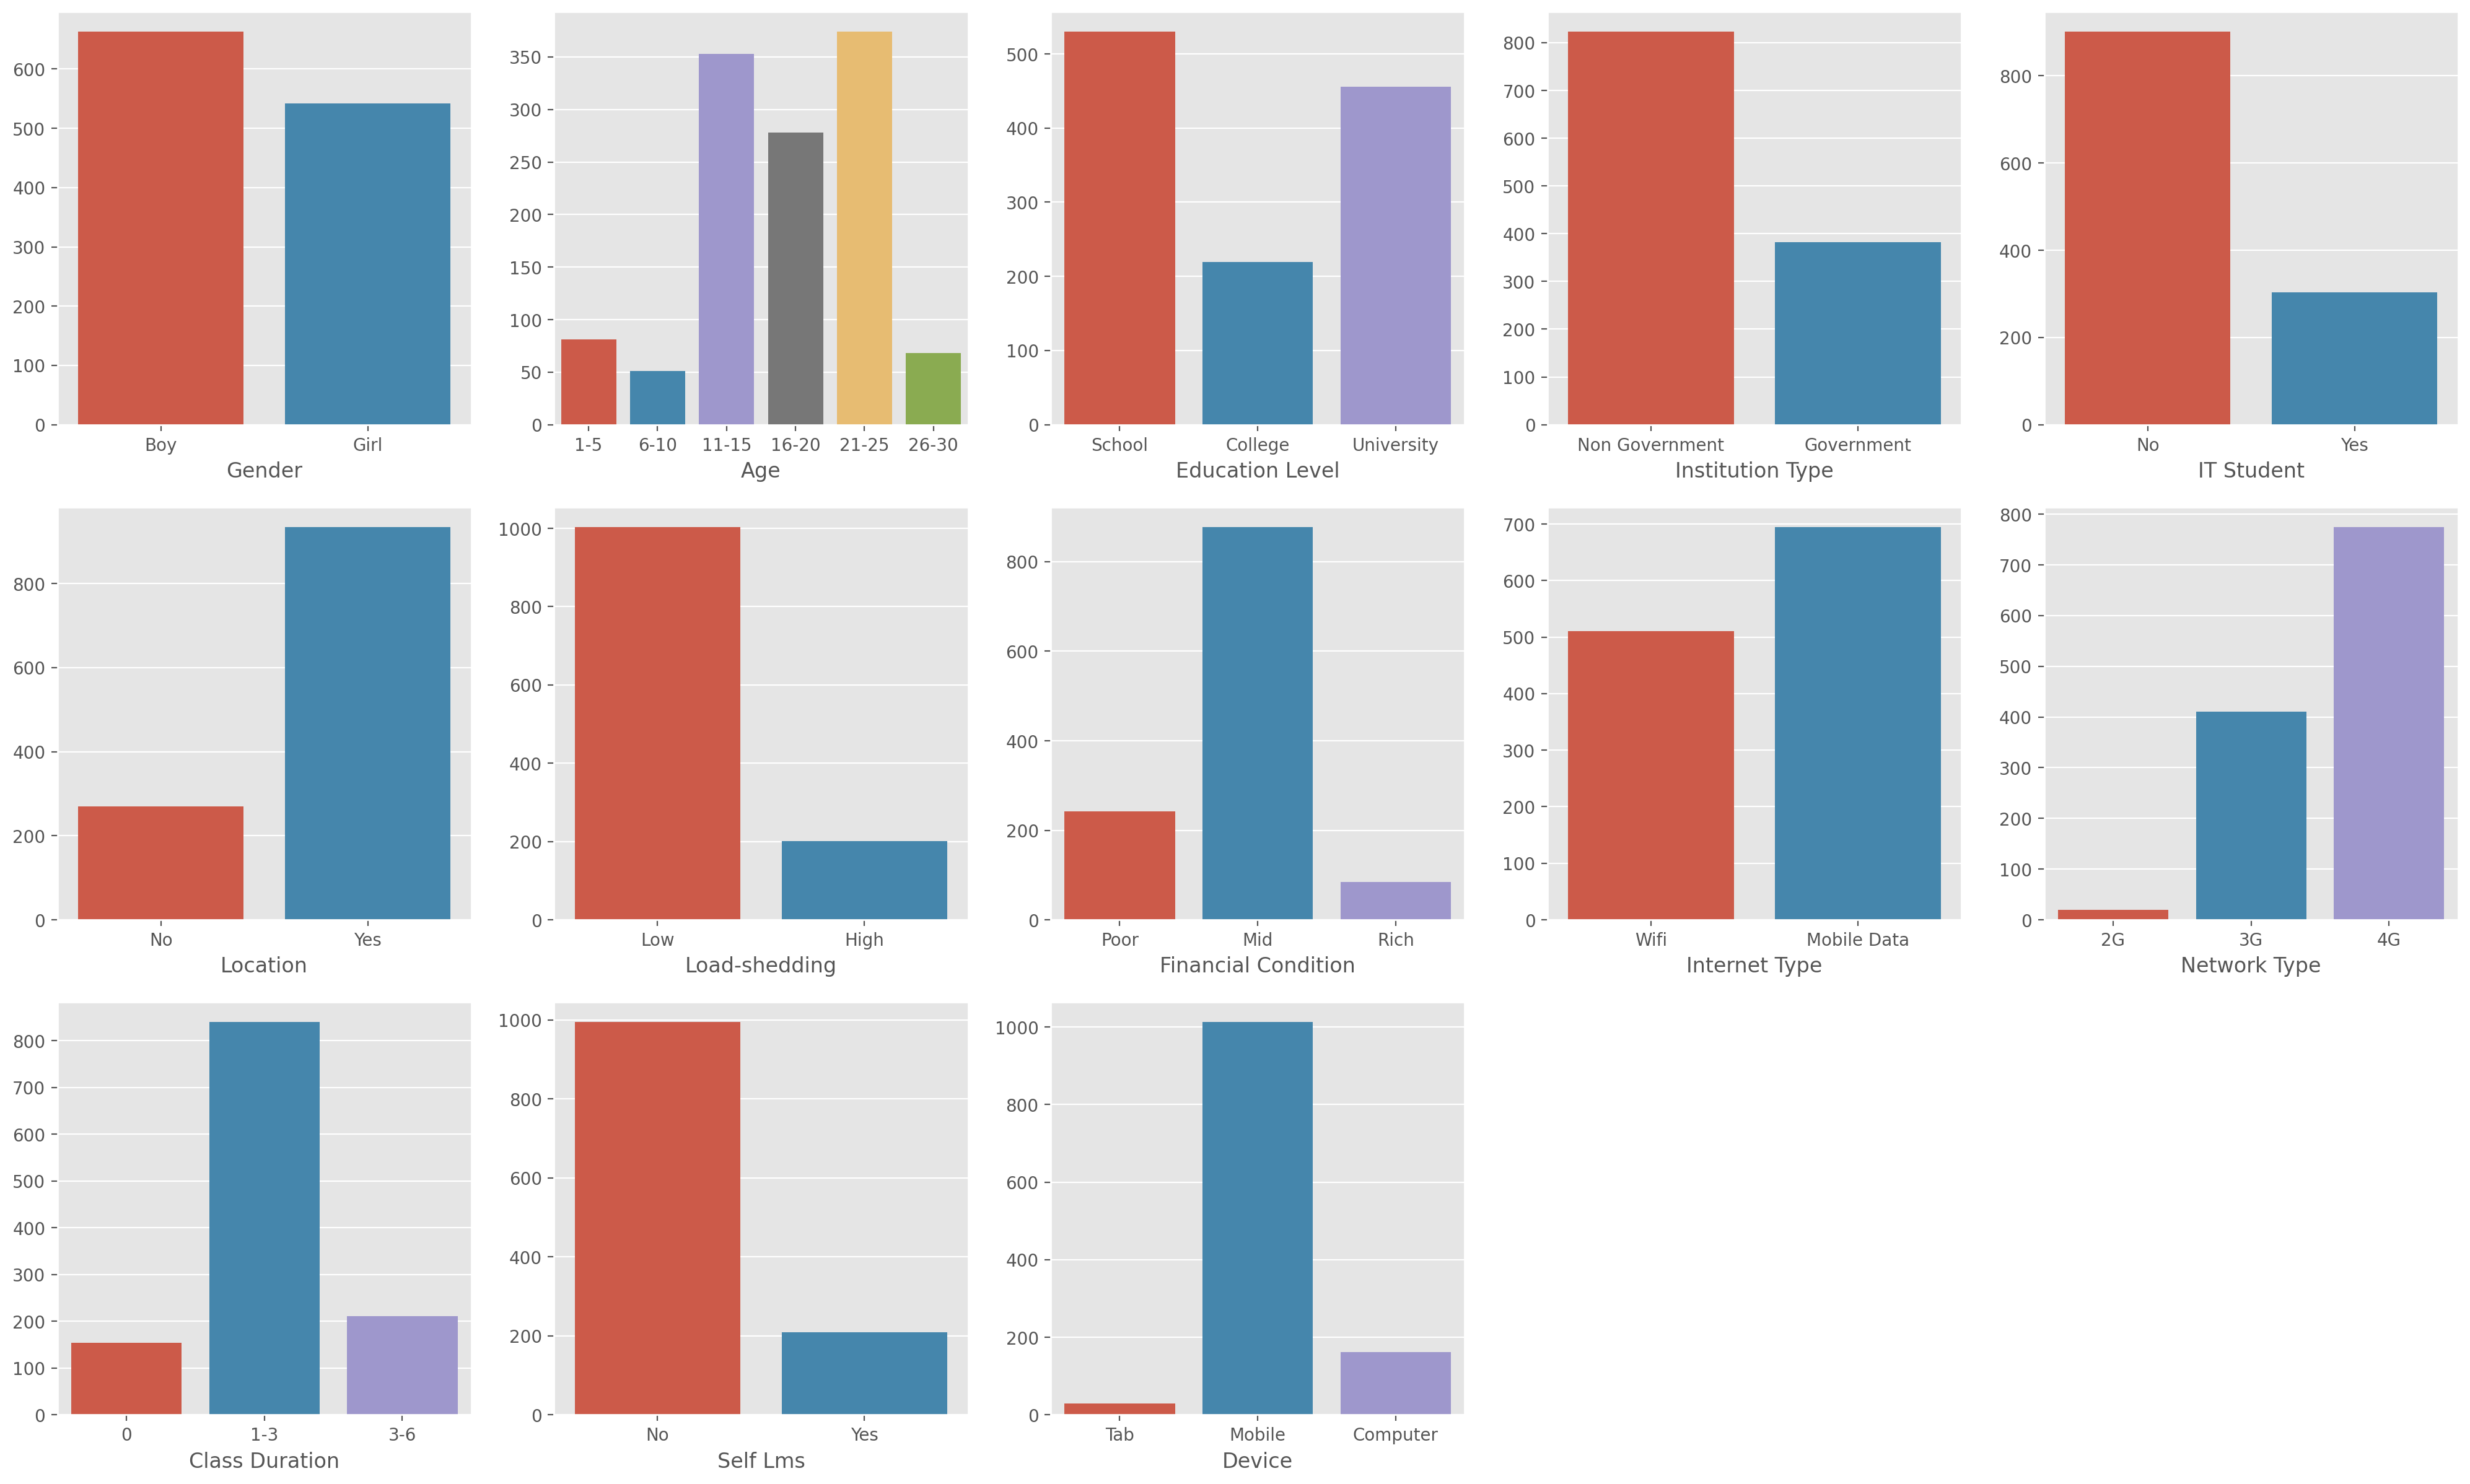

In [14]:
f = plt.figure(figsize = (25,15))
for idx, col in enumerate(data.columns[:-1]):
    ax = plt.subplot(3, 5, idx + 1)
    sns.countplot(data=data,
                  x=col,
                  order=order[col],
                  ax=ax
    )
    plt.ylabel(None)
plt.show;

### Target Distribution

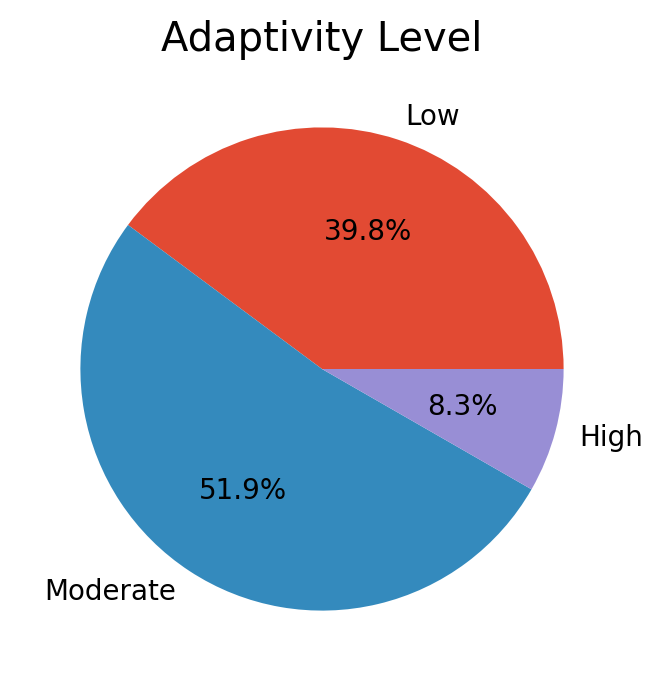

In [15]:
target_ratio = data["Adaptivity Level"].value_counts().reindex(["Low", "Moderate", "High"])
plt.title("Adaptivity Level", x=0.5)
plt.pie(target_ratio, labels=target_ratio.index, autopct="%.1f%%");

### Target - Features Distribution

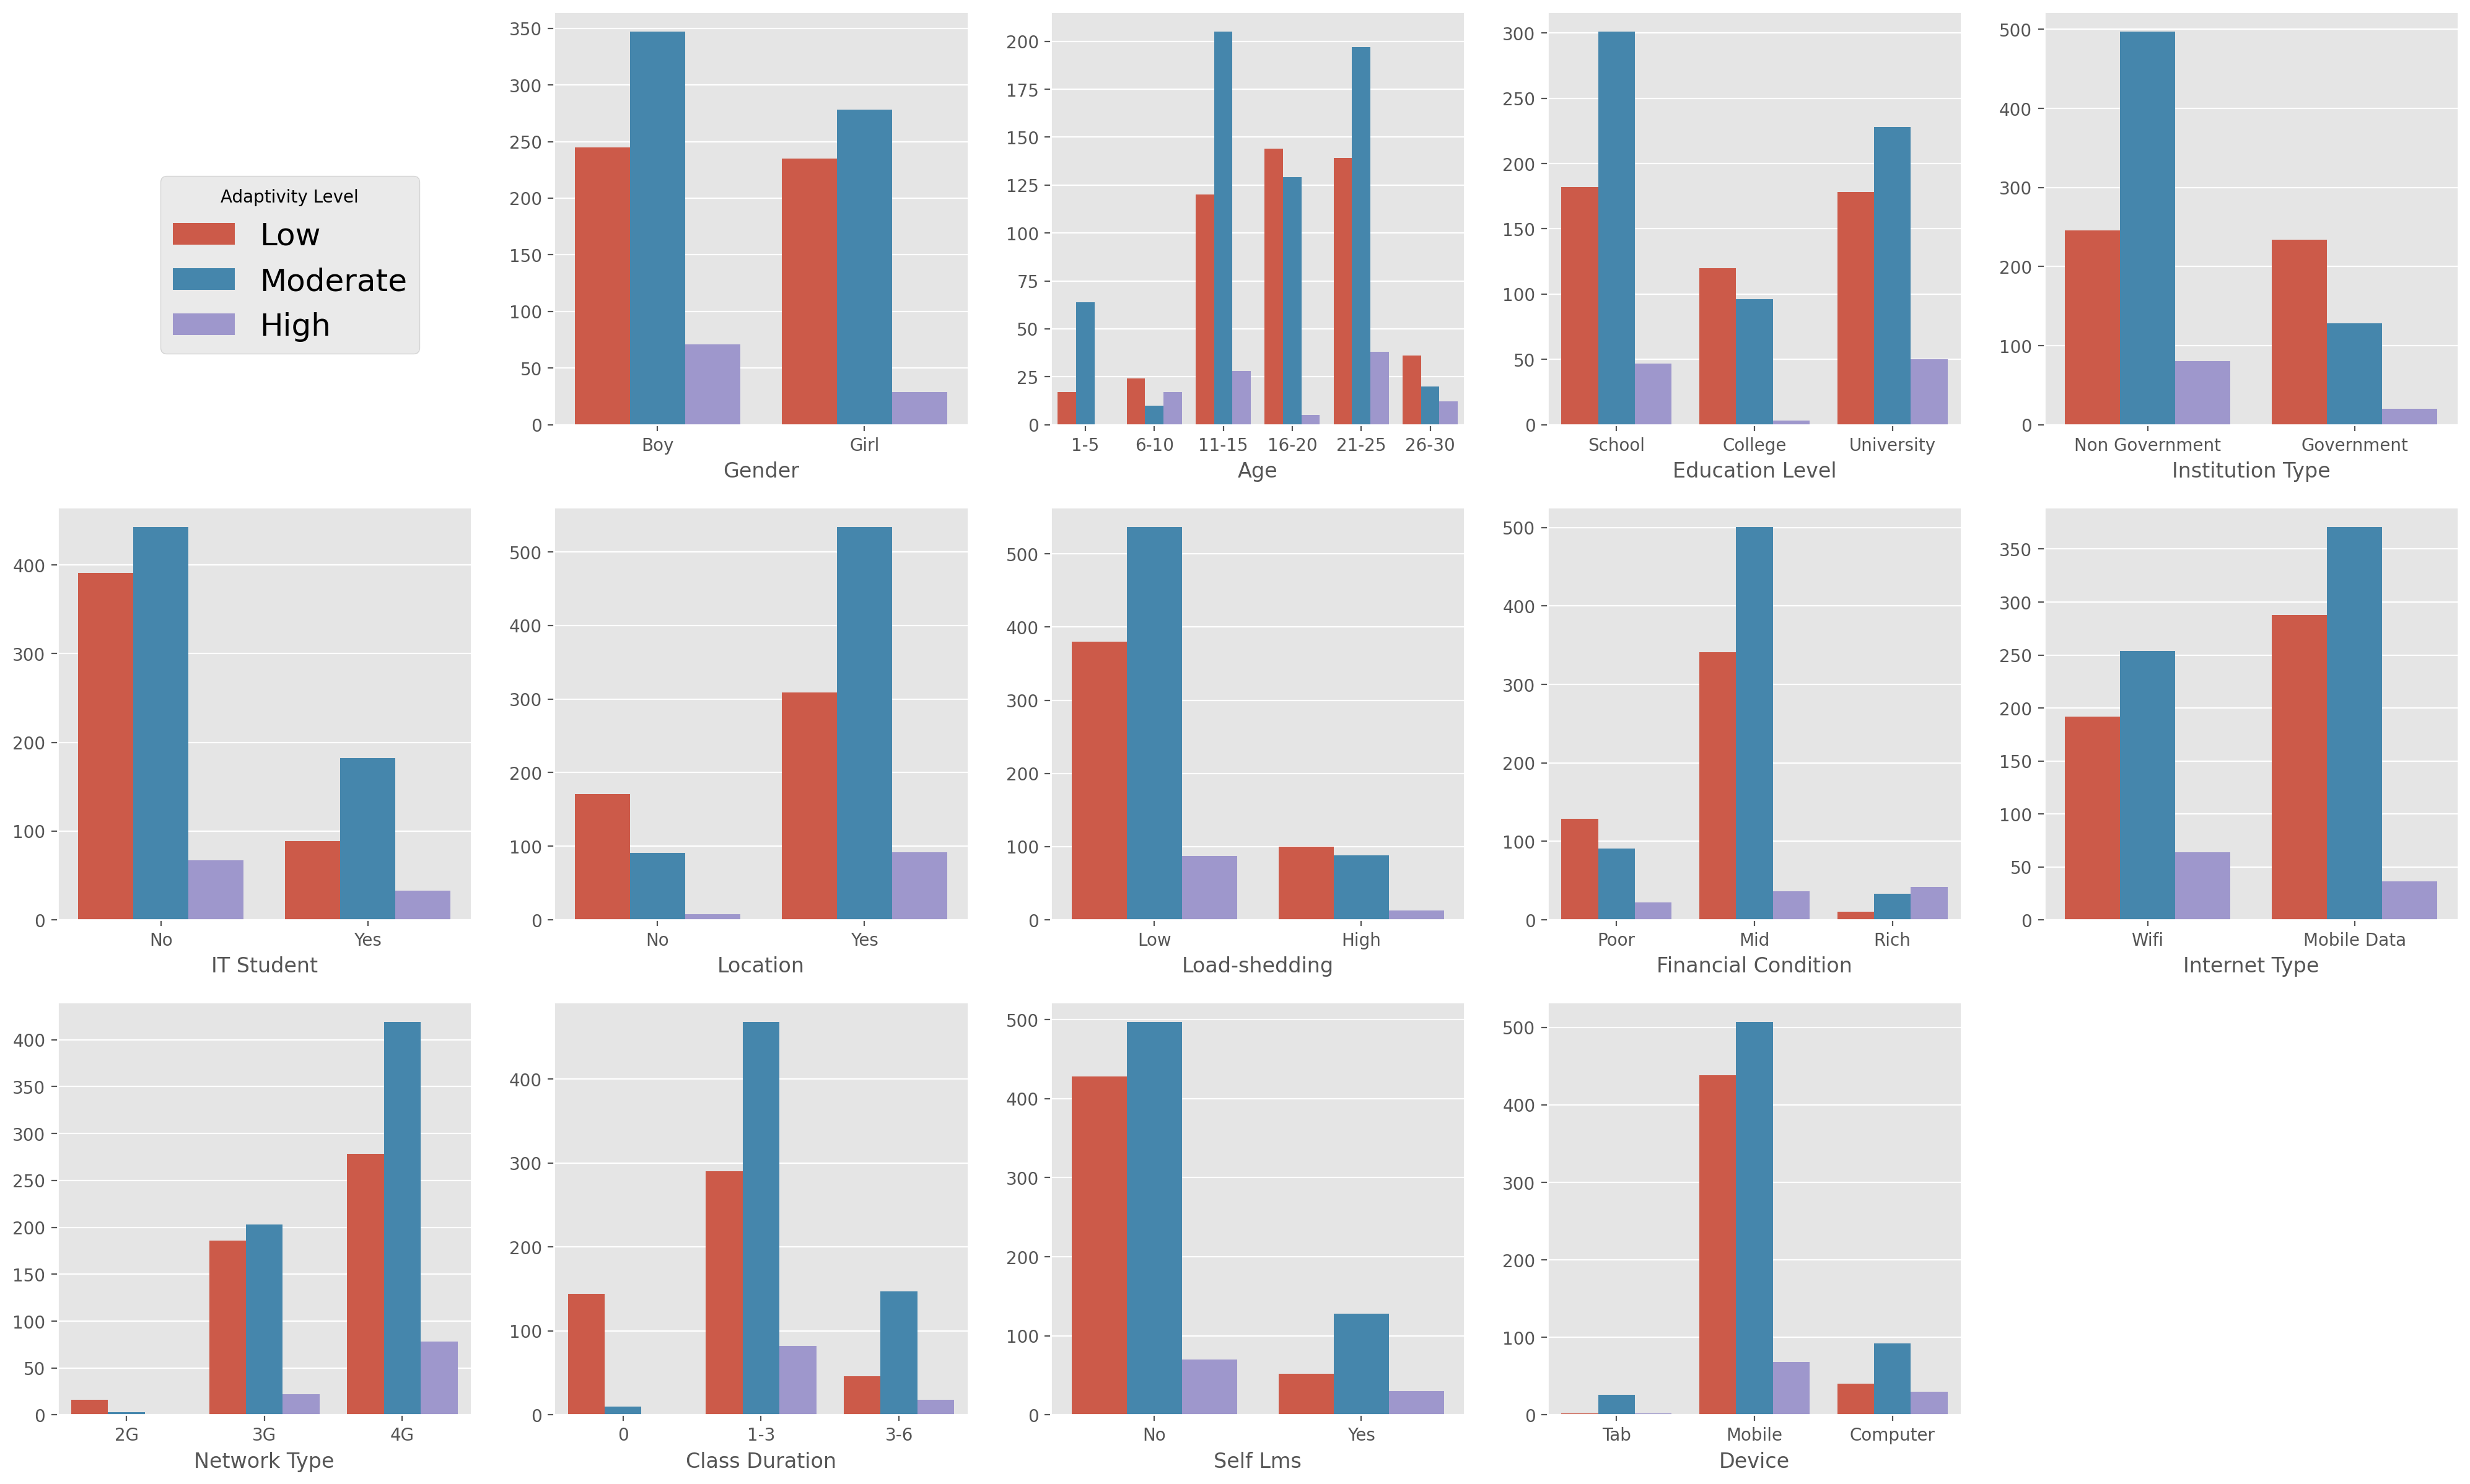

In [16]:
f = plt.figure(figsize = (25,15))
for idx, col in enumerate(data.columns[:-1]):
    ax = plt.subplot(3, 5, idx + 2)
    sns.countplot(data=data,
                  x=col,
                  hue=target,
                  hue_order=order[target],
                  order=order[col],
                  ax=ax
    )
    
    if not idx:
        handles, labels = ax.get_legend_handles_labels()
    
    ax.get_legend().remove()
    ax.set_ylabel("")
    

f.legend(handles=handles, labels=labels, loc="upper center", bbox_to_anchor=(0.2, 0.8), prop={'size': 18}, title="Adaptivity Level")
plt.show;

## Model Construction

### Ordinal Encoding

In [17]:
### to use sklearn algorithm, type of features must be numerical, so use Ordinal Encoder
mapping = []
for key, values in order.items():
    tmp_dict = dict()
    tmp_dict["col"] = key
    tmp_dict_mapping = dict()
    for idx, cat in enumerate(values):
        tmp_dict_mapping[cat] = idx

    tmp_dict["mapping"] = tmp_dict_mapping
    mapping.append(tmp_dict)
ord = OrdinalEncoder(mapping=mapping)
data_encoded = ord.fit_transform(data)

In [18]:
mapping

[{'col': 'Gender', 'mapping': {'Boy': 0, 'Girl': 1}},
 {'col': 'Age',
  'mapping': {'1-5': 0,
   '6-10': 1,
   '11-15': 2,
   '16-20': 3,
   '21-25': 4,
   '26-30': 5}},
 {'col': 'Education Level',
  'mapping': {'School': 0, 'College': 1, 'University': 2}},
 {'col': 'Institution Type',
  'mapping': {'Non Government': 0, 'Government': 1}},
 {'col': 'IT Student', 'mapping': {'No': 0, 'Yes': 1}},
 {'col': 'Location', 'mapping': {'No': 0, 'Yes': 1}},
 {'col': 'Load-shedding', 'mapping': {'Low': 0, 'High': 1}},
 {'col': 'Financial Condition', 'mapping': {'Poor': 0, 'Mid': 1, 'Rich': 2}},
 {'col': 'Internet Type', 'mapping': {'Wifi': 0, 'Mobile Data': 1}},
 {'col': 'Network Type', 'mapping': {'2G': 0, '3G': 1, '4G': 2}},
 {'col': 'Class Duration', 'mapping': {'0': 0, '1-3': 1, '3-6': 2}},
 {'col': 'Self Lms', 'mapping': {'No': 0, 'Yes': 1}},
 {'col': 'Device', 'mapping': {'Tab': 0, 'Mobile': 1, 'Computer': 2}},
 {'col': 'Adaptivity Level', 'mapping': {'Low': 0, 'Moderate': 1, 'High': 2}}]

In [19]:
data_encoded.describe()

Gender          Age  Education Level  Institution Type  \
count  1205.000000  1205.000000      1205.000000       1205.000000   
mean      0.449793     2.843983         0.938589          0.317012   
std       0.497679     1.257096         0.902863          0.465506   
min       0.000000     0.000000         0.000000          0.000000   
25%       0.000000     2.000000         0.000000          0.000000   
50%       0.000000     3.000000         1.000000          0.000000   
75%       1.000000     4.000000         2.000000          1.000000   
max       1.000000     5.000000         2.000000          1.000000   

        IT Student     Location  Load-shedding  Financial Condition  \
count  1205.000000  1205.000000    1205.000000          1205.000000   
mean      0.252282     0.775934       0.166805             0.869710   
std       0.434503     0.417139       0.372956             0.504584   
min       0.000000     0.000000       0.000000             0.000000   
25%       0.000000     1.000000       0.000000             1.000000   
50%       0.000000     1.000000       0.000000             1.000000   
75%       1.000000     1.000000       0.000000             1.000000   
max       1.000000     1.000000       1.000000             2.000000   

       Internet Type  Network Type  Class Duration     Self Lms       Device  \
count    1205.000000   1205.000000     1205.000000  1205.000000  1205.000000   
mean        0.576763      1.627386        1.047303     0.174274     1.109544   
std         0.494277      0.515295        0.548559     0.379502     0.384003   
min         0.000000      0.000000        0.000000     0.000000     0.000000   
25%         0.000000      1.000000        1.000000     0.000000     1.000000   
50%         1.000000      2.000000        1.000000     0.000000     1.000000   
75%         1.000000      2.000000        1.000000     0.000000     1.000000   
max         1.000000      2.000000        2.000000     1.000000     2.000000   

       Adaptivity Level  
count       1205.000000  
mean           0.684647  
std            0.618221  
min            0.000000  
25%            0.000000  
50%            1.000000  
75%            1.000000  
max            2.000000

### Seperate target and feature variables

In [20]:
### seperate target and feature variables
def seperate_target(data, target):
    X = data.drop(target, axis=1)
    y = data[target]
    return X, y


X, y = seperate_target(data_encoded, target)

### Split data to train and test subsets

In [21]:
### split data to train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=141592)

### Brief prediction by LazyClassifier

In [22]:
### brief prediction by LazyClassifier
from lazypredict.Supervised import LazyClassifier
lazy_X, lazy_y = X_train.copy().reset_index(drop=True), y_train.copy().reset_index(drop=True)
skf = StratifiedKFold()
pred = None
for train_index, val_index in skf.split(lazy_X, lazy_y):
    lazy_X_train, lazy_X_val = lazy_X.loc[train_index], lazy_X.loc[val_index]
    lazy_y_train, lazy_y_val = lazy_y.loc[train_index], lazy_y.loc[val_index]
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(lazy_X_train, lazy_X_val, lazy_y_train, lazy_y_val)
    if type(pred) == type(None):
        pred = models.copy()
    else:
        for i in pred.columns:
            pred[i] += models[i]
for i in pred.columns:
    pred[i] /= 5
pred.sort_values(by="F1 Score", ascending=False)

100%|██████████| 29/29 [00:01<00:00, 15.20it/s]


Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
RandomForestClassifier             0.89               0.82     NaN      0.88   
ExtraTreesClassifier               0.89               0.81     NaN      0.88   
XGBClassifier                      0.88               0.81     NaN      0.88   
DecisionTreeClassifier             0.88               0.81     NaN      0.88   
LabelPropagation                   0.88               0.81     NaN      0.88   
LabelSpreading                     0.88               0.81     NaN      0.88   
ExtraTreeClassifier                0.88               0.81     NaN      0.88   
BaggingClassifier                  0.87               0.81     NaN      0.87   
LGBMClassifier                     0.87               0.80     NaN      0.87   
SVC                                0.79               0.69     NaN      0.79   
KNeighborsClassifier               0.79               0.69     NaN      0.79   
QuadraticDiscriminantAnalysis      0.76               0.73     NaN      0.76   
AdaBoostClassifier                 0.68               0.58     NaN      0.68   
LogisticRegression                 0.69               0.53     NaN      0.67   
SGDClassifier                      0.67               0.52     NaN      0.66   
LinearDiscriminantAnalysis         0.68               0.51     NaN      0.66   
GaussianNB                         0.65               0.58     NaN      0.65   
CalibratedClassifierCV             0.68               0.49     NaN      0.64   
LinearSVC                          0.67               0.48     NaN      0.64   
RidgeClassifier                    0.67               0.48     NaN      0.64   
RidgeClassifierCV                  0.67               0.48     NaN      0.64   
PassiveAggressiveClassifier        0.64               0.48     NaN      0.63   
BernoulliNB                        0.64               0.49     NaN      0.62   
NearestCentroid                    0.55               0.55     NaN      0.59   
Perceptron                         0.60               0.46     NaN      0.58   
DummyClassifier                    0.52               0.33     NaN      0.35   

                               Time Taken  
Model                                      
RandomForestClassifier               0.20  
ExtraTreesClassifier                 0.15  
XGBClassifier                        0.45  
DecisionTreeClassifier               0.01  
LabelPropagation                     0.03  
LabelSpreading                       0.06  
ExtraTreeClassifier                  0.01  
BaggingClassifier                    0.03  
LGBMClassifier                       0.14  
SVC                                  0.08  
KNeighborsClassifier                 0.02  
QuadraticDiscriminantAnalysis        0.01  
AdaBoostClassifier                   0.09  
LogisticRegression                   0.02  
SGDClassifier                        0.05  
LinearDiscriminantAnalysis           0.03  
GaussianNB                           0.01  
CalibratedClassifierCV               0.47  
LinearSVC                            0.18  
RidgeClassifier                      0.02  
RidgeClassifierCV                    0.02  
PassiveAggressiveClassifier          0.01  
BernoulliNB                          0.01  
NearestCentroid                      0.01  
Perceptron                           0.01  
DummyClassifier                      0.01

In [23]:
### lazy predict changes pandas display option
pd.reset_option("all")

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



### Base model : mode

In [24]:
### use 3 eval metrics, which are accuracy, f1 score macro average(for multiclass), and auc score macro average by one vs rest(for multiclass)
multiscorer = {
    "accuracy":"accuracy",
    "f1_macro":"f1_macro",
    "roc_auc_ovr":"roc_auc_ovr"
}


### make base model, note that stratified and uniform are not deterministic(although f1 of stratified and accuracy of uniform will converge to 1/(# of classes))
for s in ["most_frequent", "prior", "stratified", "uniform"]:
    base = DummyClassifier(strategy=s)
    score = cross_validate(estimator=base,
                           X=X_train,
                           y=y_train,
                           cv=5,
                           scoring=multiscorer)
    print("Model : ", "base_", s, sep="")
    for i in score:
        if "test" in i:
            print(i[5:], ":", np.mean(score[i]))

Model : base_most_frequent
accuracy : 0.518674438687392
f1_macro : 0.2276871288980317
roc_auc_ovr : 0.5
Model : base_prior
accuracy : 0.518674438687392
f1_macro : 0.2276871288980317
roc_auc_ovr : 0.5
Model : base_stratified
accuracy : 0.4409056563039724
f1_macro : 0.34325712785935764
roc_auc_ovr : 0.5016032071686569
Model : base_uniform
accuracy : 0.3257124352331606
f1_macro : 0.29129707534587035
roc_auc_ovr : 0.5


In [25]:
### base model : mode
base = DummyClassifier(strategy="most_frequent")
score = cross_validate(estimator=base,
                       X=X_train,
                       y=y_train,
                       cv=5,
                       scoring=multiscorer)
scores = ["base_most_frequent", np.mean(score["test_accuracy"]), np.mean(score["test_f1_macro"]), np.mean(score["test_roc_auc_ovr"])]
scores = pd.DataFrame(data=np.array(scores), index = ["model", "accuracy", "f1_macro", "roc_auc_ovr"]).T
for i in scores.columns[1:]:
    scores[i] = scores[i].astype(float)

In [26]:
scores

model  accuracy  f1_macro  roc_auc_ovr
0  base_most_frequent  0.518674  0.227687          0.5

### Models
- Logistic Regression : "logreg"
- Decision Tree Classifier : "dt"
- Random Forest Classifier : "rf"
- XGBoost Classifier : "xgb"  

### Data Balancing (prefix)
- None : "none"
- Oversampling by RandomOverSampler : "os_rand"
- Oversampling by SMOTEN : "os_smoten"
- Class Weighting : "wc"

In [27]:
### make ternary classification models by Logistic Regression, Decision Tree Classifier, Random Forest Classifier, and XGBoost Classifier
estimators = ["logreg", "dt", "rf", "xgb"]


### since it is classificaition on imbalanced data, we can use oversampling and weighted class
balancing_methods = ["none", "os_rand", "os_smoten", "wc"]


### make pipelines for each model
pipelines = dict()
from itertools import product
for estimator, balancing in product(estimators, balancing_methods):
    if estimator == "logreg":
        pipeline = Pipeline([(estimator, LogisticRegression(
            multi_class="ovr",
            n_jobs=-1
        ))])
    elif estimator == "dt":
        pipeline = Pipeline([(estimator, DecisionTreeClassifier())])
    elif estimator == "rf":
        pipeline = Pipeline([(estimator, RandomForestClassifier(
            n_estimators=1000,
            n_jobs=-1
        ))])
    elif estimator == "xgb":
        pipeline = Pipeline([(estimator, XGBClassifier(
            n_estimators=500,
            tree_method="gpu_hist",
        ))])
    
    if balancing == "os_rand":
        pipeline.steps.insert(0, (balancing, RandomOverSampler()))
    elif balancing == "os_smoten":
        pipeline.steps.insert(0, (balancing, SMOTEN()))
    elif (estimator != "xgb") and (balancing == "wc"):
        pipeline[-1].set_params(class_weight="balanced")
    pipelines[estimator+"_"+balancing] = pipeline

sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)

In [28]:
### base model and not tuned models
scores = scores.drop(scores.index[1:])
pipelines_base = dict()
for key in pipelines:
    pipelines_base[key] = clone(pipelines[key])
    model_score = [key]
    acc = []
    f1 = []
    auc = []
    for _ in range(10):
        if key == "xgb_wc":
            score = cross_validate(estimator=pipelines_base[key],
                                X=X_train,
                                y=y_train,
                                cv=5,
                                scoring=multiscorer,
                                fit_params={"xgb__sample_weight":sample_weight})
        else:
            score = cross_validate(estimator=pipelines_base[key],
                                X=X_train,
                                y=y_train,
                                cv=5,
                                scoring=multiscorer)
        for i in score:
            if i == "test_accuracy":
                acc.append(np.mean(score[i]))
            if i == "test_f1_macro":
                f1.append(np.mean(score[i]))
            if i == "test_roc_auc_ovr":
                auc.append(np.mean(score[i]))
    model_score.append(np.mean(acc))
    model_score.append(np.mean(f1))
    model_score.append(np.mean(auc))
    scores.loc[len(scores)] = model_score

In [29]:
### draw colors at maximum
def draw_color_at_maxmum(x,color):
    color = f'border:{color}'
    _max = x.max()
    is_max = x == _max
    return [color if b else '' for b in is_max]


scores.style.apply(draw_color_at_maxmum,color='2px solid yellow',subset=scores.columns[1:],axis=0)

## Hyperparameter Tuning by hyperopt Library

In [30]:
### hyperparameter tuning
n = len(X_train.columns)
min_sampling_features = min(0.25, np.sqrt(n)/n, np.log2(n)/n)
reg_candidate = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 5, 10, 100]
param_logreg = {
    "logreg__C":hp.choice("C", np.logspace(-5, 4, 10))
}
param_dt = {
    "dt__max_depth":hp.quniform("max_depth", 2, 50, 2),
    "dt__max_features":hp.uniform("max_features", min_sampling_features, 1),
    "dt__min_samples_leaf":hp.quniform("min_samples_leaf", 1, 16, 1),
}
param_rf = {
    "rf__max_depth":hp.quniform("max_depth", 2, 20, 2),
    "rf__max_features":hp.uniform("max_features", min_sampling_features, 1),
    "rf__min_samples_leaf":hp.quniform("min_samples_leaf", 1, 16, 1),
}
param_xgb = {
    "xgb__n_estimators":hp.quniform("n_estimators", 100, 1100, 100),
    "xgb__max_depth":hp.quniform("max_depth", 4, 22, 2),
    "xgb__colsample_bytree":hp.uniform("colsample_bytree", min_sampling_features, 0.8),
    "xgb__min_child_weight":hp.quniform("min_child_weight", 1, 16, 1),
    "xgb__learning_rate":hp.uniform("learning_rate", 0.001, 0.5),
    "xgb__reg_lambda":hp.choice('reg_lambda', reg_candidate),
}

Note that we need to change dtype **inside custom function** for interger hyperparameter like `max_depth`, `min_samples_leaf` for using hyperopt object

In [31]:
### since hyperopt loss function needs only one value, use f1 score(macro) as eval metric

### it takes too long on kaggle notebook, so I'll just put codes that I ran
# trials = dict()
# best_params = dict()
# for key, values in pipelines.items():
#     def myloss(params):
#         pipe = values
#         for i in params:
#             if "max_depth" in i or "n_estimators" in i or "min" in i:
#                 params[i] = int(params[i]) # interger dtype change
#         pipe.set_params(**params)
#         if key == "xgb_wc":
#             score = cross_val_score(estimator=pipe,
#                                     X=X_train,
#                                     y=y_train,
#                                     cv=5,
#                                     scoring="f1_macro",
#                                     fit_params={"xgb__sample_weight":sample_weight})
#         else:
#             score = cross_val_score(estimator=pipe,
#                                     X=X_train,
#                                     y=y_train,
#                                     cv=5,
#                                     scoring="f1_macro") # cross-validation scoring
#         avg_cv_score = -np.mean(score) # note that hyperopt use loss function, so we need negation for "higher is better" score
#         return {"loss": avg_cv_score, "status": STATUS_OK}
    

#     if "dt" in key:
#         space = param_dt
#     elif "rf" in key:
#         space = param_rf
#     elif "xgb" in key:
#         space = param_xgb
#     else:
#         space = param_logreg

#     trials[key] = Trials()
#     best_params[key] = fmin(
#         fn=myloss,
#         trials=trials[key],
#         space=space,
#         algo=tpe.suggest,
#         max_evals=100
#     )

load `trials` and `best_params` from url


In [32]:
import joblib
from urllib.request import urlopen
trials = joblib.load(urlopen("https://raw.githubusercontent.com/line1029/student_adaptability_level_classification/main/trials.pkl"))
best_params = joblib.load(urlopen("https://raw.githubusercontent.com/line1029/student_adaptability_level_classification/main/best_params.pkl"))

We can access each trials in `Trials()` object

In [33]:
trials

{'logreg_none': <hyperopt.base.Trials at 0x7f1bba13c3d0>,
 'logreg_os_rand': <hyperopt.base.Trials at 0x7f1bba0b5ad0>,
 'logreg_os_smoten': <hyperopt.base.Trials at 0x7f1bb9e1ac10>,
 'logreg_wc': <hyperopt.base.Trials at 0x7f1bb9faa850>,
 'dt_none': <hyperopt.base.Trials at 0x7f1bba167b50>,
 'dt_os_rand': <hyperopt.base.Trials at 0x7f1bb99c2a50>,
 'dt_os_smoten': <hyperopt.base.Trials at 0x7f1bb9cf3610>,
 'dt_wc': <hyperopt.base.Trials at 0x7f1bb9d2a090>,
 'rf_none': <hyperopt.base.Trials at 0x7f1bb99a9550>,
 'rf_os_rand': <hyperopt.base.Trials at 0x7f1bba203f10>,
 'rf_os_smoten': <hyperopt.base.Trials at 0x7f1bb99bdfd0>,
 'rf_wc': <hyperopt.base.Trials at 0x7f1bb9cc5890>,
 'xgb_none': <hyperopt.base.Trials at 0x7f1bba2da390>,
 'xgb_os_rand': <hyperopt.base.Trials at 0x7f1bb99d2bd0>,
 'xgb_os_smoten': <hyperopt.base.Trials at 0x7f1bb99cd910>,
 'xgb_wc': <hyperopt.base.Trials at 0x7f1bba130950>}

Each trials stored at `.trials` attribute of `Trials()` object

In [34]:
trials['xgb_none'].trials[-1]

{'state': 2,
 'tid': 99,
 'spec': None,
 'result': {'loss': -0.7390127139753868, 'status': 'ok'},
 'misc': {'tid': 99,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bytree': [99],
   'learning_rate': [99],
   'max_depth': [99],
   'min_child_weight': [99],
   'n_estimators': [99],
   'reg_lambda': [99]},
  'vals': {'colsample_bytree': [0.5699919194215634],
   'learning_rate': [0.06629442922340134],
   'max_depth': [10.0],
   'min_child_weight': [15.0],
   'n_estimators': [1000.0],
   'reg_lambda': [4]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 12, 10, 6, 9, 16, 381000),
 'refresh_time': datetime.datetime(2022, 12, 10, 6, 9, 28, 515000)}

Best trial stored at `.best_trial` attribute. Note that we can get best parameter by key `"vals"` of `.best_trial["misc"]`. But be cautious because values of dict`Trials().best_trial["misc"]["vals"]` has type `list`

In [35]:
trials['xgb_none'].best_trial

{'state': 2,
 'tid': 30,
 'spec': None,
 'result': {'loss': -0.8494213058277351, 'status': 'ok'},
 'misc': {'tid': 30,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bytree': [30],
   'learning_rate': [30],
   'max_depth': [30],
   'min_child_weight': [30],
   'n_estimators': [30],
   'reg_lambda': [30]},
  'vals': {'colsample_bytree': [0.722852767178741],
   'learning_rate': [0.2851157073658148],
   'max_depth': [8.0],
   'min_child_weight': [2.0],
   'n_estimators': [900.0],
   'reg_lambda': [4]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 12, 10, 5, 43, 3, 69000),
 'refresh_time': datetime.datetime(2022, 12, 10, 5, 43, 19, 503000)}

Parameter from `hp.choice` indicate index of candidate. In below case, `"reg_lambda"` is such parameter

In [36]:
trials['xgb_none'].best_trial["misc"]["vals"]

{'colsample_bytree': [0.722852767178741],
 'learning_rate': [0.2851157073658148],
 'max_depth': [8.0],
 'min_child_weight': [2.0],
 'n_estimators': [900.0],
 'reg_lambda': [4]}

In [37]:
reg_candidate[4]

0.1

Final hyperparameter also returned by `fmin` function(stored at dict `best_params`)

In [38]:
best_params

{'logreg_none': {'C': 9},
 'logreg_os_rand': {'C': 6},
 'logreg_os_smoten': {'C': 6},
 'logreg_wc': {'C': 5},
 'dt_none': {'max_depth': 50.0,
  'max_features': 0.5958231166786487,
  'min_samples_leaf': 1.0},
 'dt_os_rand': {'max_depth': 36.0,
  'max_features': 0.2991367412358107,
  'min_samples_leaf': 1.0},
 'dt_os_smoten': {'max_depth': 42.0,
  'max_features': 0.7404920659700179,
  'min_samples_leaf': 1.0},
 'dt_wc': {'max_depth': 26.0,
  'max_features': 0.892526065555118,
  'min_samples_leaf': 1.0},
 'rf_none': {'max_depth': 20.0,
  'max_features': 0.8483340633594209,
  'min_samples_leaf': 1.0},
 'rf_os_rand': {'max_depth': 14.0,
  'max_features': 0.2584542882454861,
  'min_samples_leaf': 1.0},
 'rf_os_smoten': {'max_depth': 18.0,
  'max_features': 0.6403372742786909,
  'min_samples_leaf': 1.0},
 'rf_wc': {'max_depth': 16.0,
  'max_features': 0.2712534039163664,
  'min_samples_leaf': 1.0},
 'xgb_none': {'colsample_bytree': 0.722852767178741,
  'learning_rate': 0.2851157073658148,
  '

These parameter are not type `list`, but still indicates index for `hp.choice`

In [39]:
best_params["xgb_none"]

{'colsample_bytree': 0.722852767178741,
 'learning_rate': 0.2851157073658148,
 'max_depth': 8.0,
 'min_child_weight': 2.0,
 'n_estimators': 900.0,
 'reg_lambda': 4}

### Optimal Hyperparameter

In [40]:
for key, trial in trials.items():
    print("Model : ", key)
    print("Optimal Hyperparameter : ", best_params[key])
    print("Optimal F1 : ", -trial.best_trial["result"]["loss"], "\n")

Model :  logreg_none
Optimal Hyperparameter :  {'C': 9}
Optimal F1 :  0.521108848597361 

Model :  logreg_os_rand
Optimal Hyperparameter :  {'C': 6}
Optimal F1 :  0.5500035757785372 

Model :  logreg_os_smoten
Optimal Hyperparameter :  {'C': 6}
Optimal F1 :  0.5628601145756015 

Model :  logreg_wc
Optimal Hyperparameter :  {'C': 5}
Optimal F1 :  0.5604174647629876 

Model :  dt_none
Optimal Hyperparameter :  {'max_depth': 50.0, 'max_features': 0.5958231166786487, 'min_samples_leaf': 1.0}
Optimal F1 :  0.8372575790386421 

Model :  dt_os_rand
Optimal Hyperparameter :  {'max_depth': 36.0, 'max_features': 0.2991367412358107, 'min_samples_leaf': 1.0}
Optimal F1 :  0.8258367478508084 

Model :  dt_os_smoten
Optimal Hyperparameter :  {'max_depth': 42.0, 'max_features': 0.7404920659700179, 'min_samples_leaf': 1.0}
Optimal F1 :  0.8091053332676005 

Model :  dt_wc
Optimal Hyperparameter :  {'max_depth': 26.0, 'max_features': 0.892526065555118, 'min_samples_leaf': 1.0}
Optimal F1 :  0.831408675

### copy and check other eval metrics with optimal hyperparameter

In [41]:
### copy optimal hyperparameter
import copy
optimal_hp = dict()
for key in trials:
    optimal_hp[key] = copy.deepcopy(trials[key].best_trial["misc"]["vals"])
    for hps in optimal_hp[key]:
        optimal_hp[key][hps] = optimal_hp[key][hps][0]
        if "max_depth" in hps or "n_estimators" in hps or "min" in hps:
            optimal_hp[key][hps] = int(optimal_hp[key][hps])
        if hps == "C":
            optimal_hp[key][hps] = np.logspace(-5, 4, 10)[optimal_hp[key][hps]]
        if hps == "reg_lambda":
            optimal_hp[key][hps] = reg_candidate[optimal_hp[key][hps]]

In [42]:
### check other eval metrics with optimal hyperparameter
scores_not_tuned = scores.copy()
scores = scores.drop(scores.index[1:])
pipelines_optimal = dict()
for key in pipelines:
    pipelines_optimal[key] = clone(pipelines[key])
    model_score = [key]

    pipelines_optimal[key][-1].set_params(**optimal_hp[key])
    if key == "xgb_wc":
        score = cross_validate(estimator=pipelines_optimal[key],
                            X=X_train,
                            y=y_train,
                            cv=5,
                            scoring=multiscorer,
                            return_train_score=True,
                            fit_params={"xgb__sample_weight":sample_weight})
    else:
        score = cross_validate(estimator=pipelines_optimal[key],
                            X=X_train,
                            y=y_train,
                            cv=5,
                            scoring=multiscorer,
                            return_train_score=True,)
    for i in score:
        if i == "test_accuracy":
            model_score.append(np.mean(score[i]))
        if i == "test_f1_macro":
            model_score.append(np.mean(score[i]))
        if i == "test_roc_auc_ovr":
            model_score.append(np.mean(score[i]))
    scores.loc[len(scores)] = model_score

In [43]:
scores.style.apply(draw_color_at_maxmum,color='2px solid yellow',subset=scores.columns[1:],axis=0)

### Final Model : XGB with not weighted class

In [44]:
### optimal model will be XGBClassifier with not weighted class
optimal_model = XGBClassifier(
    n_estimators=500,
    tree_method="gpu_hist",
    random_state=271828
)
optimal_model.set_params(**optimal_hp["xgb_none"])

optimal_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.722852767178741, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=0, gpu_id=0,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2851157073658148,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=8,
              max_leaves=0, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=900, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=271828, reg_alpha=0, ...)

In [45]:
### save model
# import joblib
# joblib.dump(optimal_model, "./xgb_optimal_model_v1.6.2.pkl")

In [46]:
### load model
# optimal_model = joblib.load(urlopen("https://raw.githubusercontent.com/line1029/student_adaptability_level_classification/main/xgb_optimal_model_v1.6.2.pkl"))

## Model Evaluation

### Classification Report

In [47]:
y_pred = optimal_model.predict(X_test)
report = classification_report(y_test, y_pred, digits=5)
print(report)

              precision    recall  f1-score   support

           0    0.88776   0.90625   0.89691        96
           1    0.90551   0.92000   0.91270       125
           2    0.93750   0.75000   0.83333        20

    accuracy                        0.90041       241
   macro avg    0.91026   0.85875   0.88098       241
weighted avg    0.90109   0.90041   0.89982       241



### Reverse mapping for encoded values

In [48]:
reverse_mapping = dict()
for feature in mapping:
    tmp = dict()
    key = feature["col"]
    for k, v in feature["mapping"].items():
        tmp[v] = k
    reverse_mapping[key] = tmp
target_mapping = reverse_mapping[target]
reverse_mapping

{'Gender': {0: 'Boy', 1: 'Girl'},
 'Age': {0: '1-5', 1: '6-10', 2: '11-15', 3: '16-20', 4: '21-25', 5: '26-30'},
 'Education Level': {0: 'School', 1: 'College', 2: 'University'},
 'Institution Type': {0: 'Non Government', 1: 'Government'},
 'IT Student': {0: 'No', 1: 'Yes'},
 'Location': {0: 'No', 1: 'Yes'},
 'Load-shedding': {0: 'Low', 1: 'High'},
 'Financial Condition': {0: 'Poor', 1: 'Mid', 2: 'Rich'},
 'Internet Type': {0: 'Wifi', 1: 'Mobile Data'},
 'Network Type': {0: '2G', 1: '3G', 2: '4G'},
 'Class Duration': {0: '0', 1: '1-3', 2: '3-6'},
 'Self Lms': {0: 'No', 1: 'Yes'},
 'Device': {0: 'Tab', 1: 'Mobile', 2: 'Computer'},
 'Adaptivity Level': {0: 'Low', 1: 'Moderate', 2: 'High'}}

In [49]:
target_mapping

{0: 'Low', 1: 'Moderate', 2: 'High'}

### ROC Curve

In [50]:
y_score = optimal_model.predict_proba(X_test)
roc_auc_score(y_test, y_score, multi_class="ovr")

0.9856014762226729

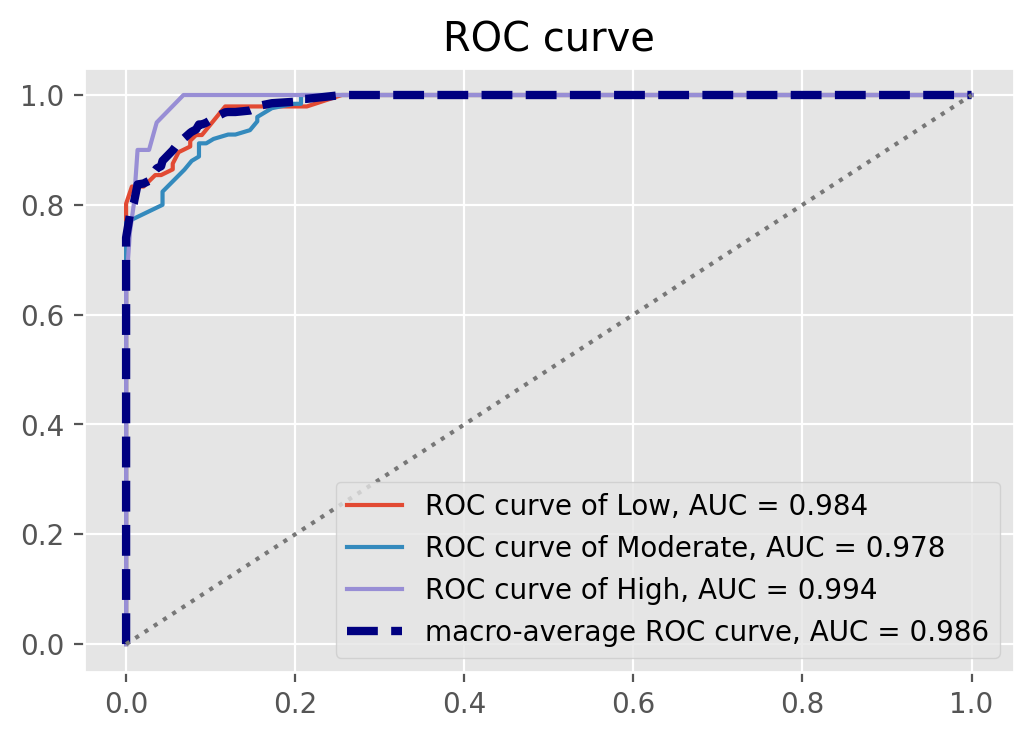

In [51]:
from sklearn.metrics import RocCurveDisplay, auc
plt.title("ROC curve")
n_classes = len(target_mapping)
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(n_classes):
    y_true = y_test == i
    fpr[i], tpr[i], thres = roc_curve(y_true, y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label="ROC curve of {0}, AUC = {1:0.3f}".format(target_mapping[i], roc_auc[i]))

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = np.append(np.append([0], all_fpr),[1])
tpr["macro"] = np.append(np.append([0], mean_tpr),[1])
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve, AUC = {0:0.3f}".format(roc_auc["macro"]),
    color="navy",
    linestyle="--",
    lw=3
)


plt.plot([0,1], [0,1], linestyle=":")

plt.legend();

### Compare score with base model
Since this is our final model, we'll evaluate model with our test subset

In [52]:
### base model : mode
base = DummyClassifier(strategy="most_frequent")
base.fit(X_train, y_train)
final_scores = ["base_most_frequent", base.score(X_test, y_test), f1_score(y_test, base.predict(X_test), average="macro"), roc_auc_score(y_test, base.predict_proba(X_test), multi_class="ovr")]
final_scores = pd.DataFrame(data=np.array(final_scores), index = ["model", "accuracy", "f1_macro", "roc_auc_ovr"]).T
for i in final_scores.columns[1:]:
    final_scores[i] = final_scores[i].astype(float)
final_scores.loc[len(final_scores)] = ["optimal_model", optimal_model.score(X_test, y_test), f1_score(y_test, y_pred, average="macro"), roc_auc_score(y_test, y_score, multi_class="ovr")]
final_scores

model  accuracy  f1_macro  roc_auc_ovr
0  base_most_frequent  0.518672  0.227687     0.500000
1       optimal_model  0.900415  0.880980     0.985601

## Model Interpretation / XAI

### Feature Importance (MDI)

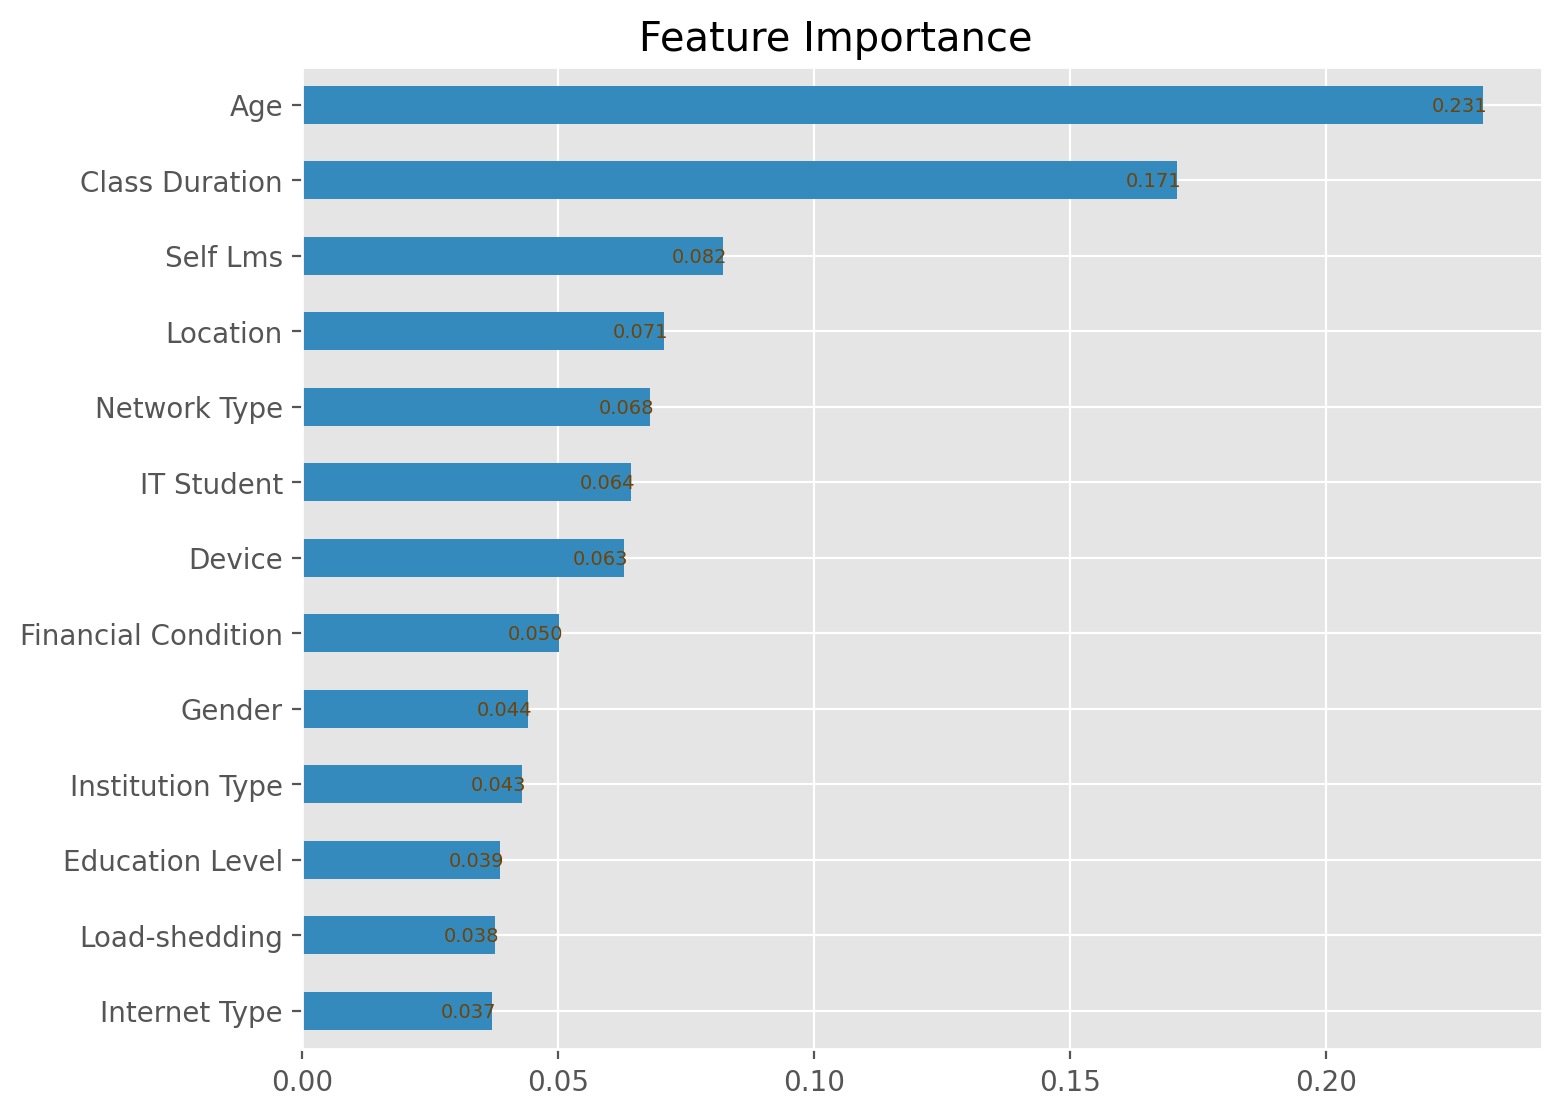

In [53]:
fi = pd.Series(data=optimal_model.feature_importances_, index=X_train.columns).sort_values()
plt.figure(figsize=(8,6.5))
fi.plot.barh(color="#348ABD")
plt.title("Feature Importance", x=0.43)
for i, c in enumerate(fi.index):
    plt.text(x=fi.loc[c]-0.01, y=i-0.01, s="{0:.3f}".format(fi.loc[c]), fontsize=7, ha="left", va = "center", color="#704409")

Permutation Importance (Mean Decrease F1_macro)

In [54]:
permuter = PermutationImportance(
    estimator=optimal_model,
    scoring="f1_macro",
    n_iter=100,
    random_state=42
)

permuter.fit(X_test, y_test)

PermutationImportance(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.722852767178741,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=0,
                                              gpu_id=0, grow_policy='depthwise',
                                              importance_type=None,
                                              interaction_constraints='',
                                              learning_rate=0.2851157073658148,
                                              max_bin=256, max_cat_to_onehot=4,
                                         

In [55]:
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=X_test.columns.tolist()
)


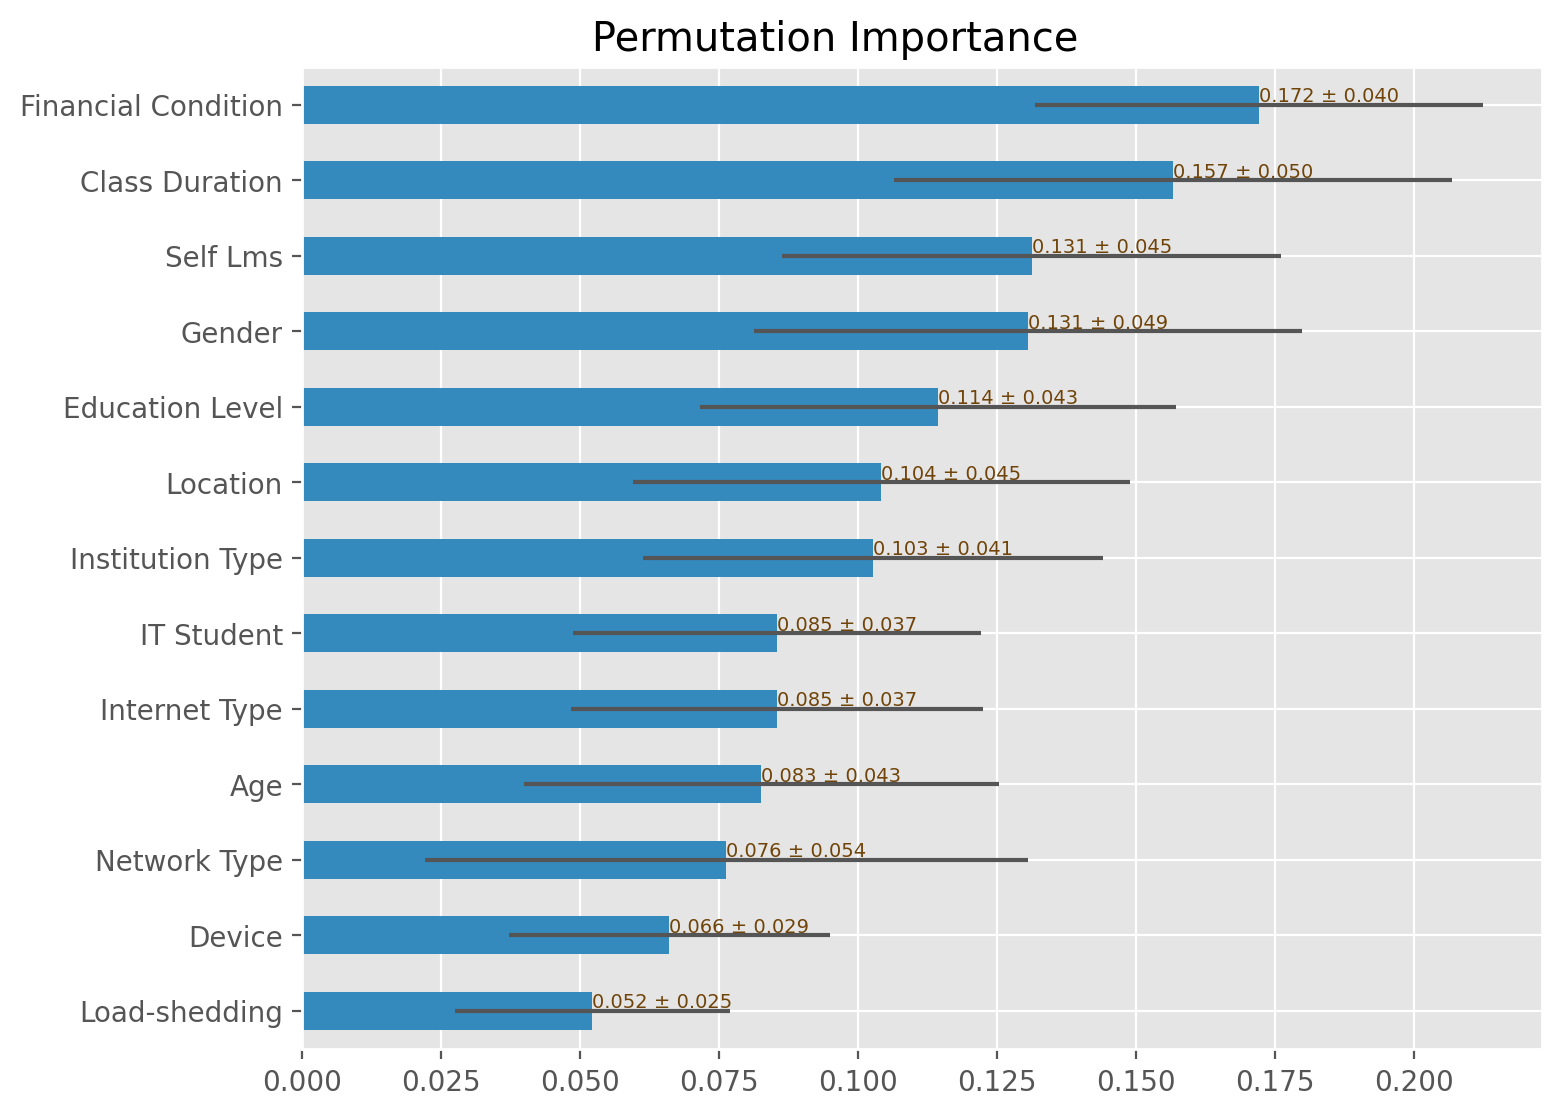

In [56]:
plt.figure(figsize=(8,6.5))
pi = pd.DataFrame(np.array([permuter.feature_importances_, permuter.feature_importances_std_*2]).T, index=X_test.columns, columns=["Permutation Importance", "std"])
pi = pi.sort_values(by="Permutation Importance")
pi, std = pi["Permutation Importance"], pi["std"]
pi.plot.barh(color="#348ABD", xerr=std)
plt.title("Permutation Importance", x=0.43)
for i, c in enumerate(pi.index):
    plt.text(x=pi.loc[c], y=i-0.01, s="{0:.3f} ± {1:.3f}".format(pi.loc[c], std.loc[c]), fontsize=7, ha="left", va = "bottom", color="#704409")

### 1-feature PDP Plot

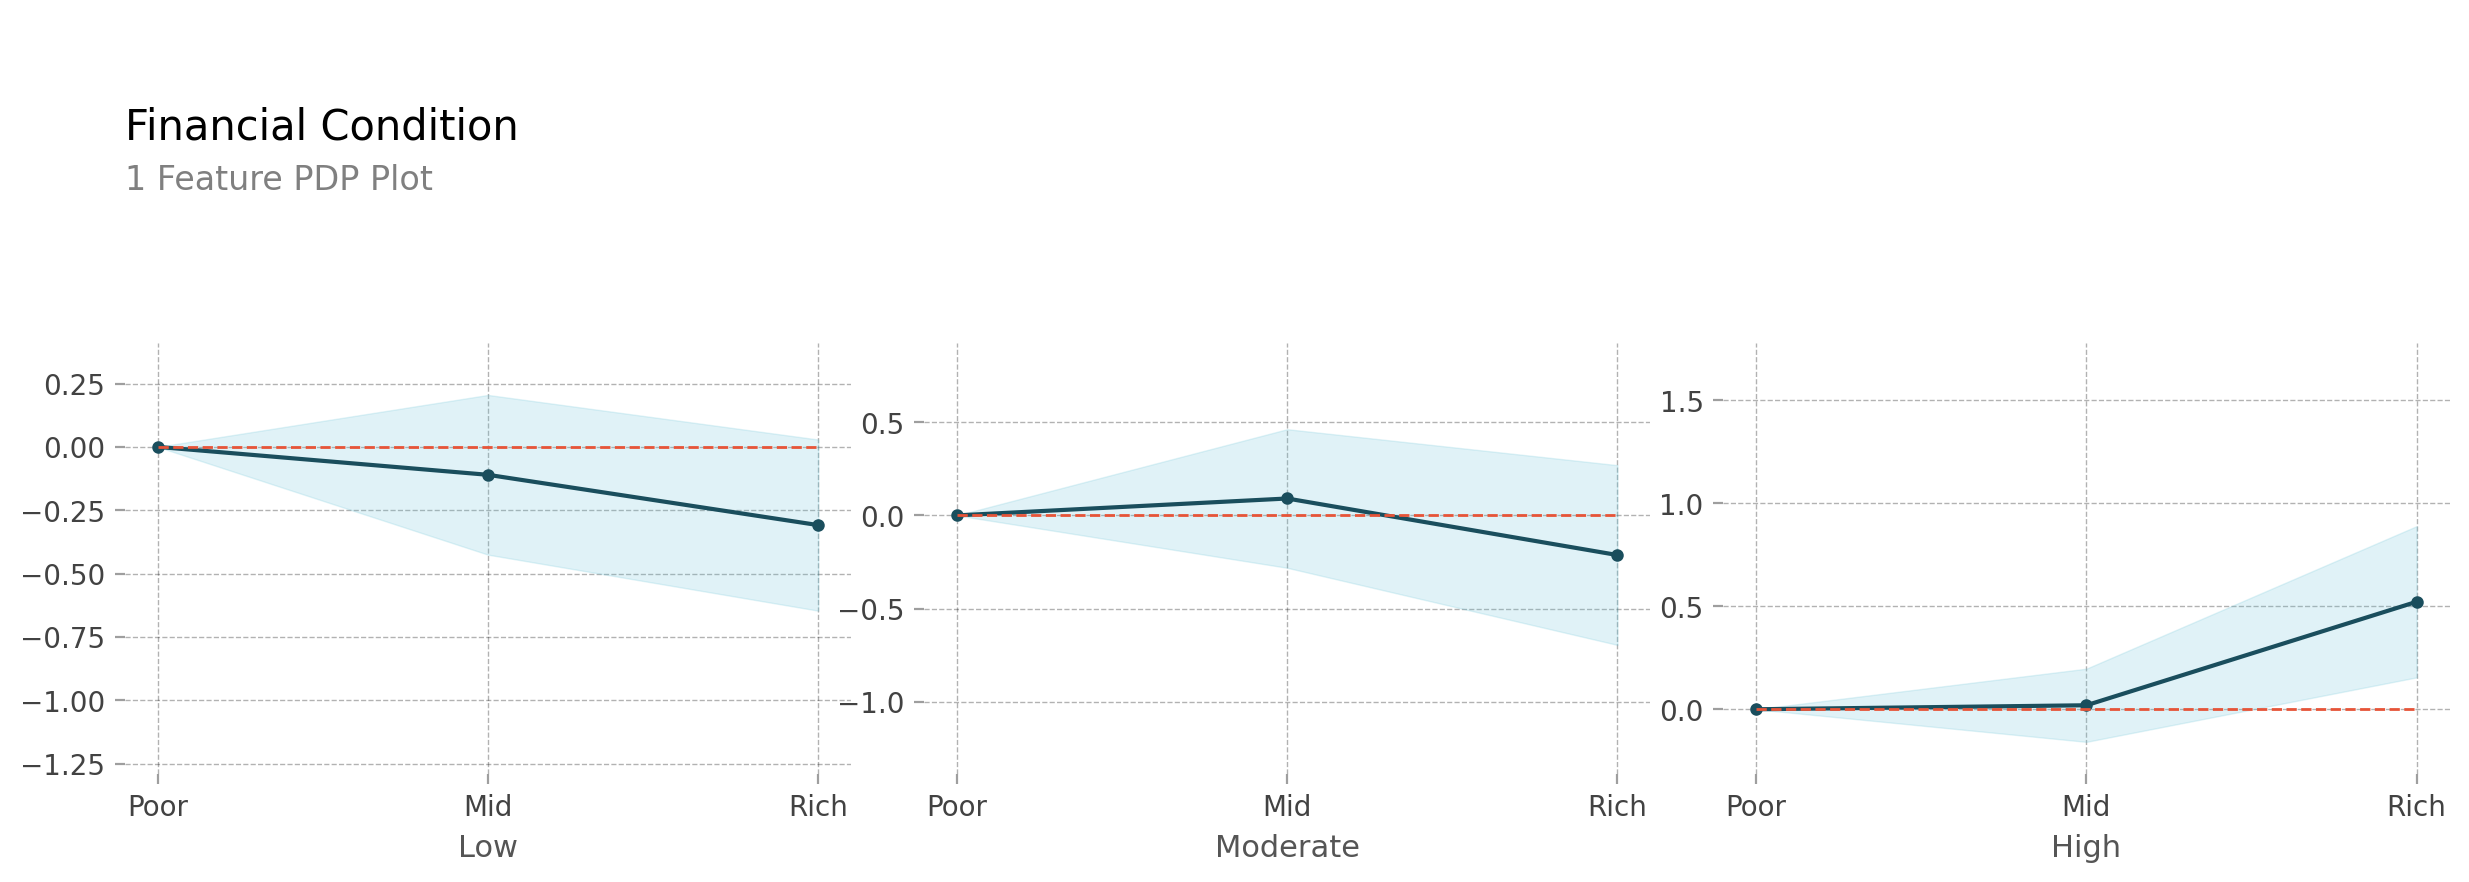

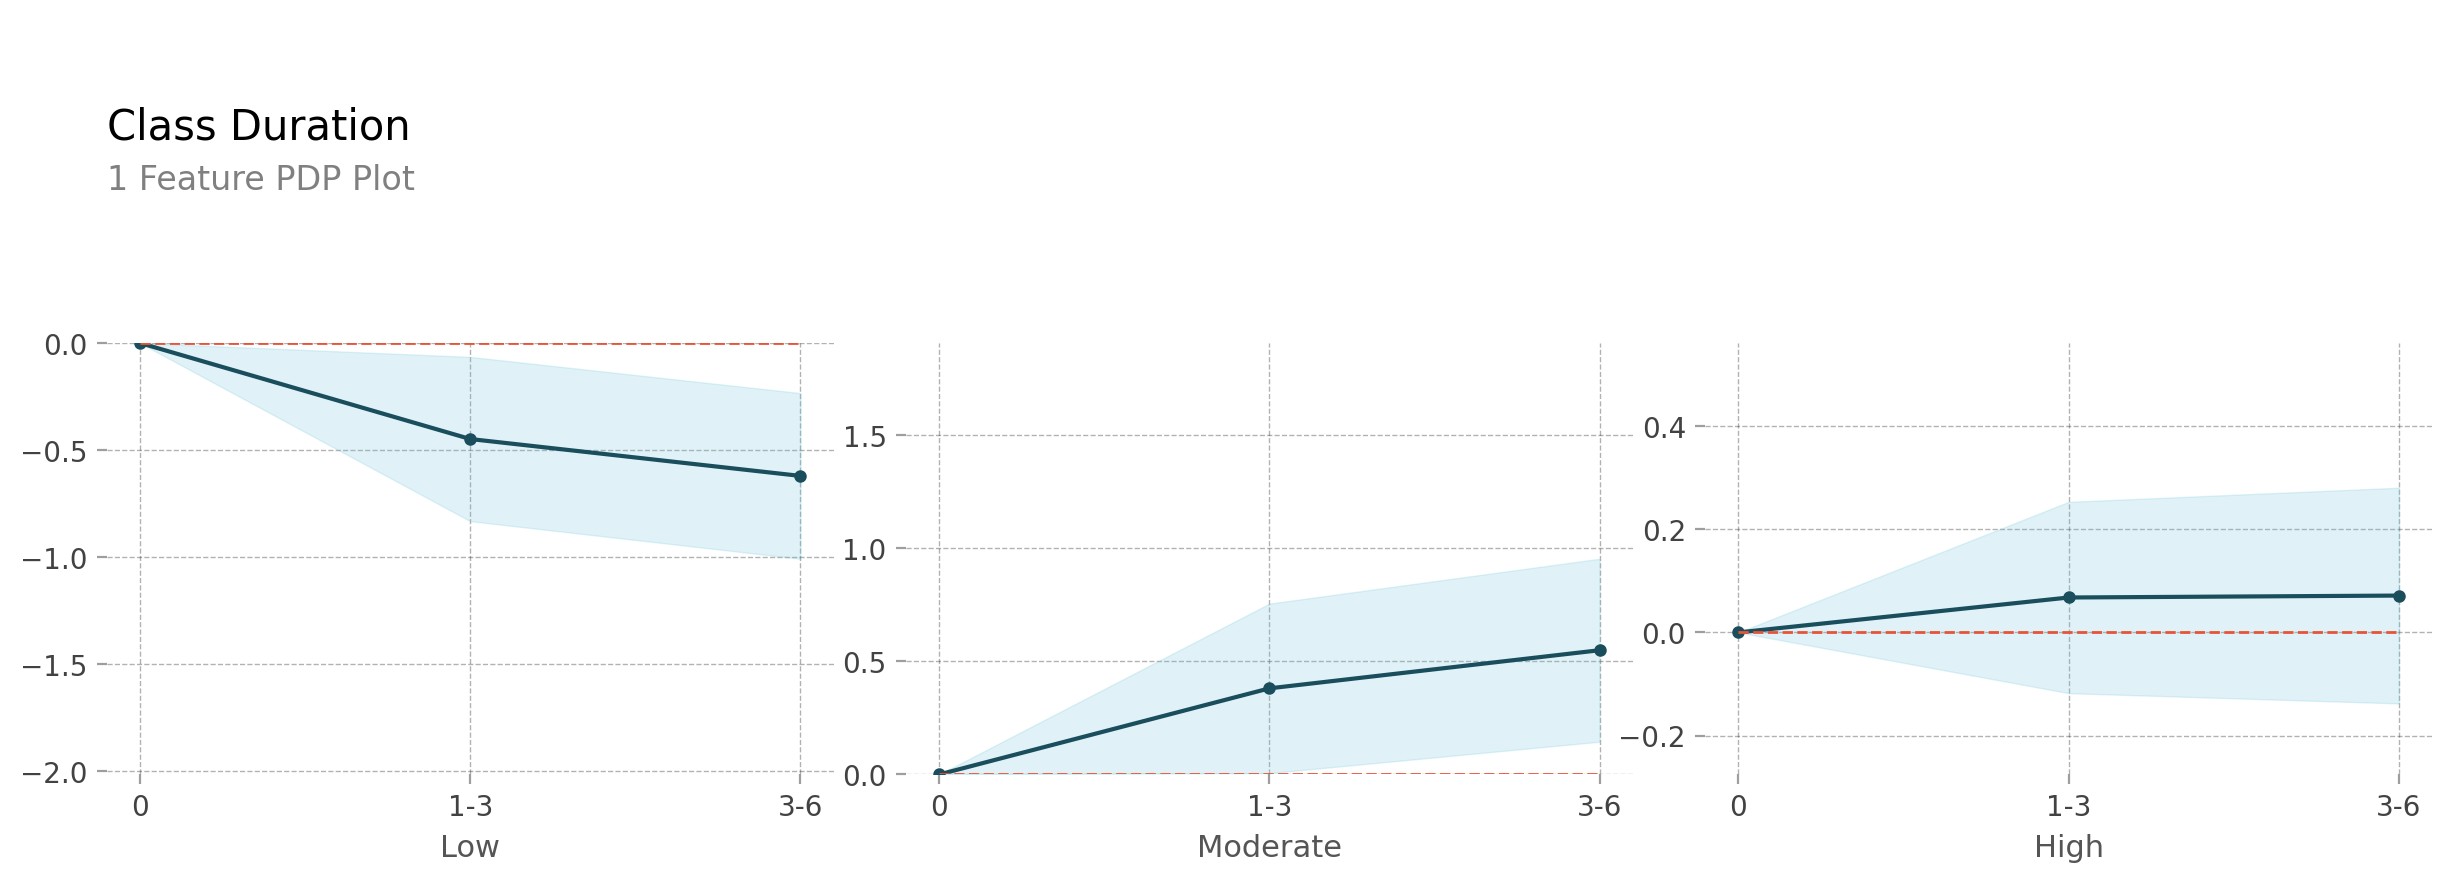

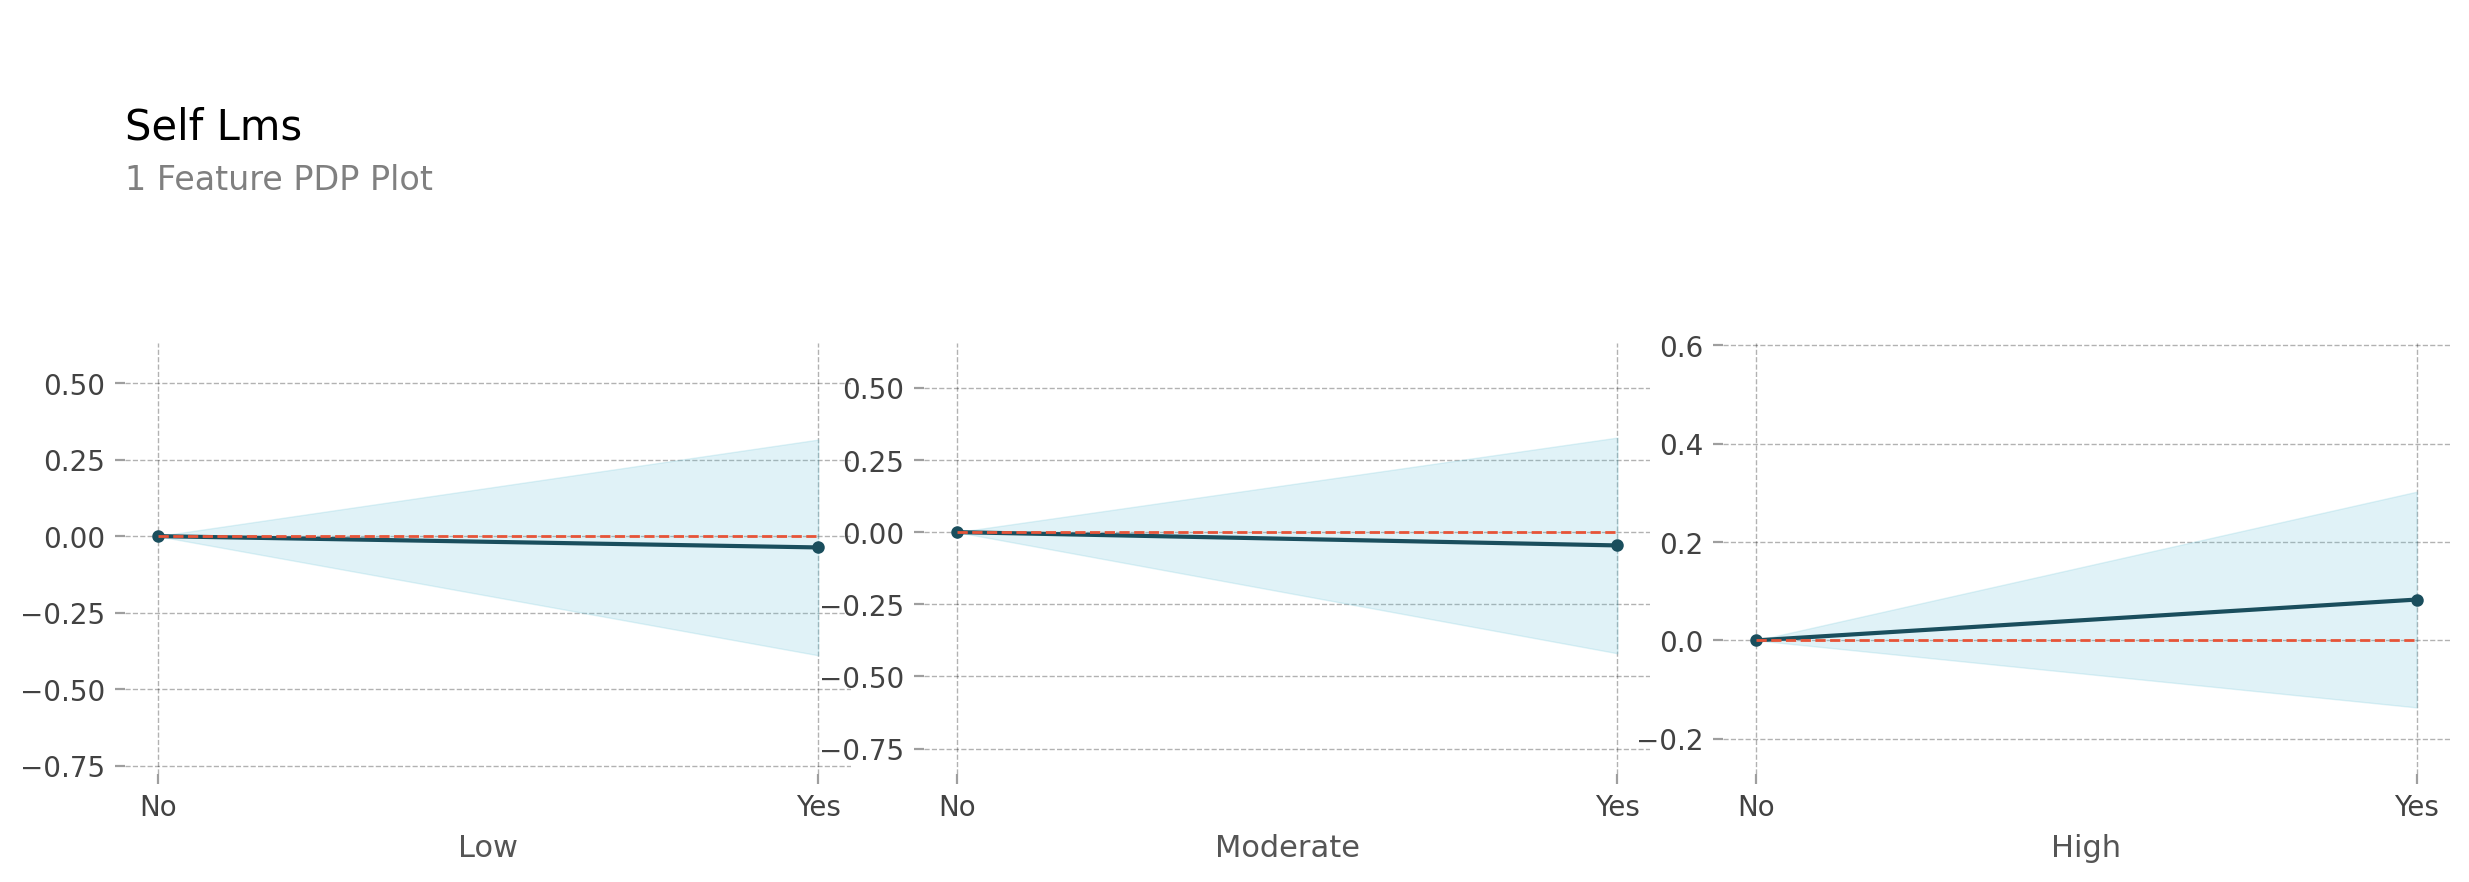

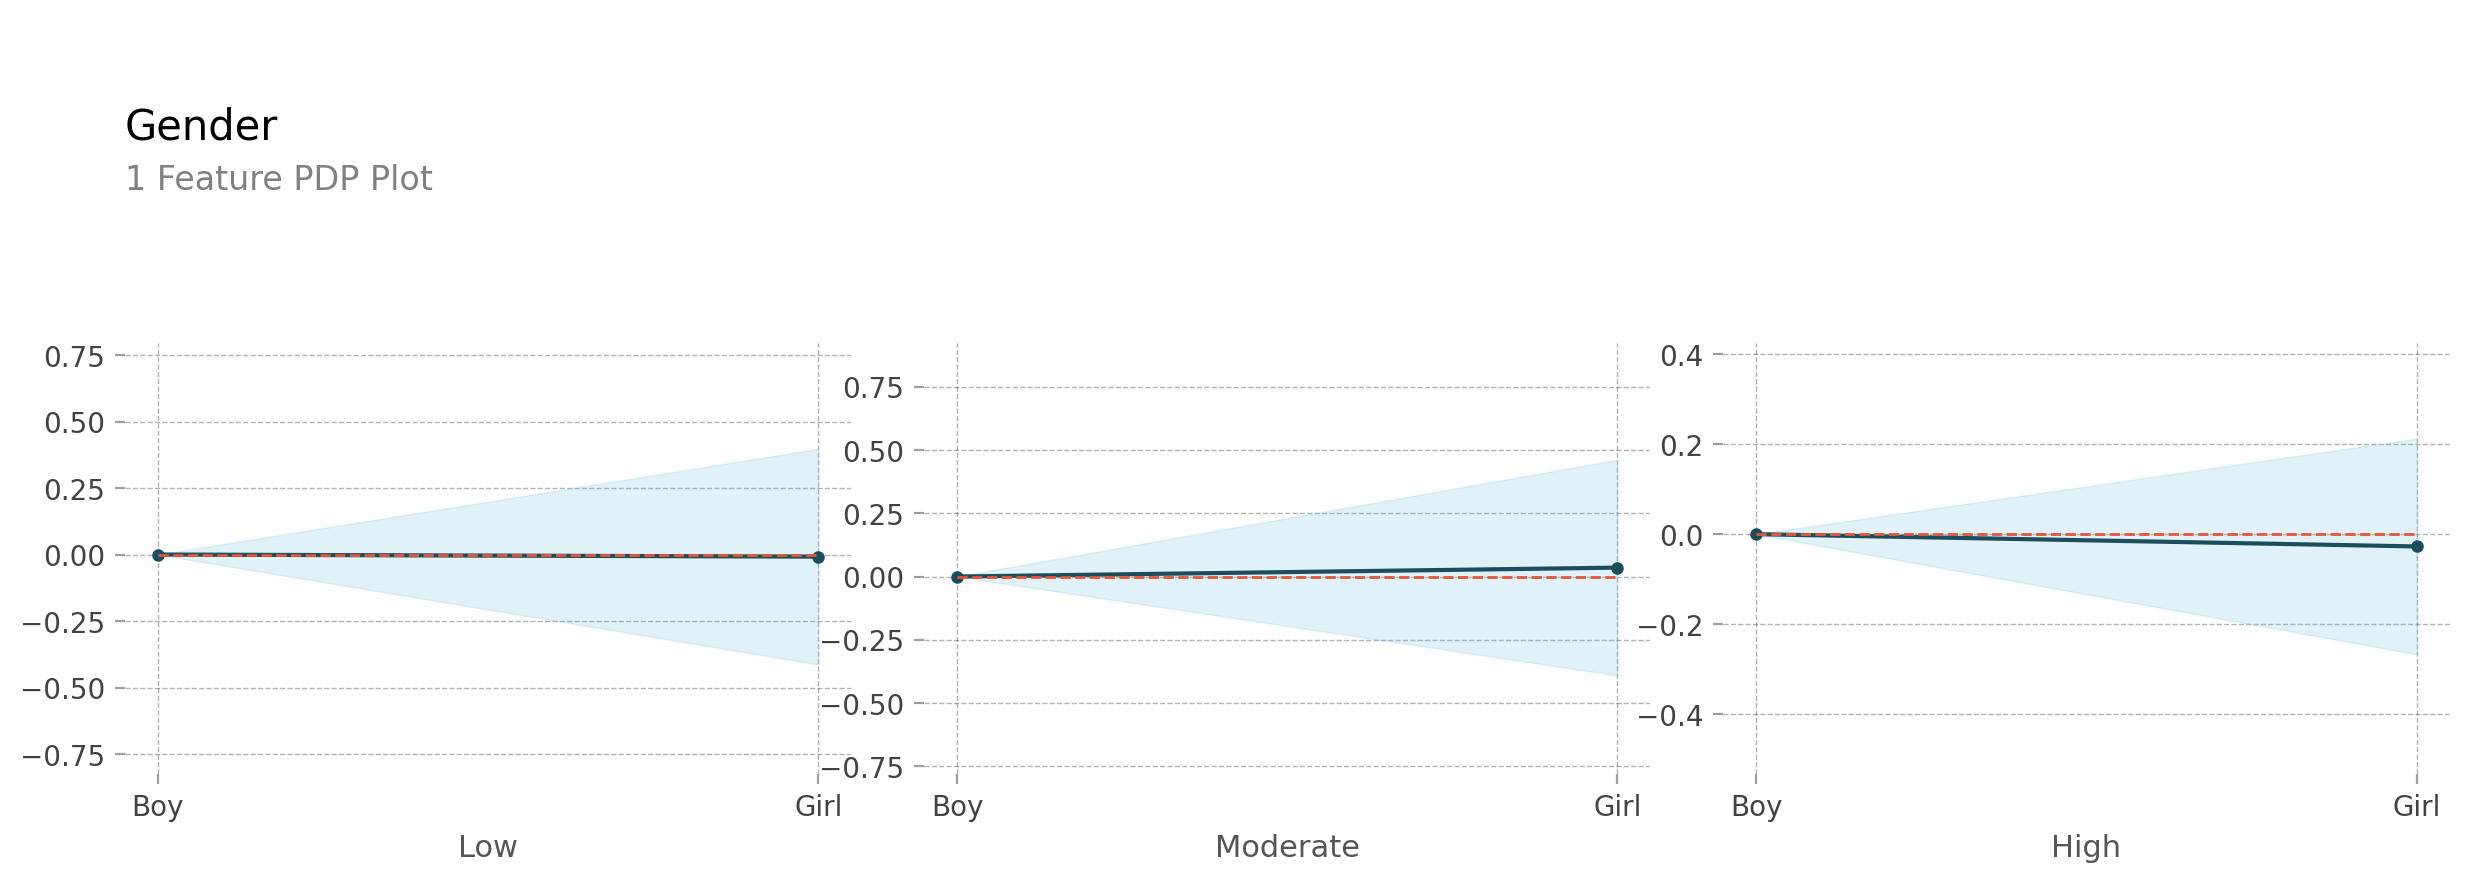

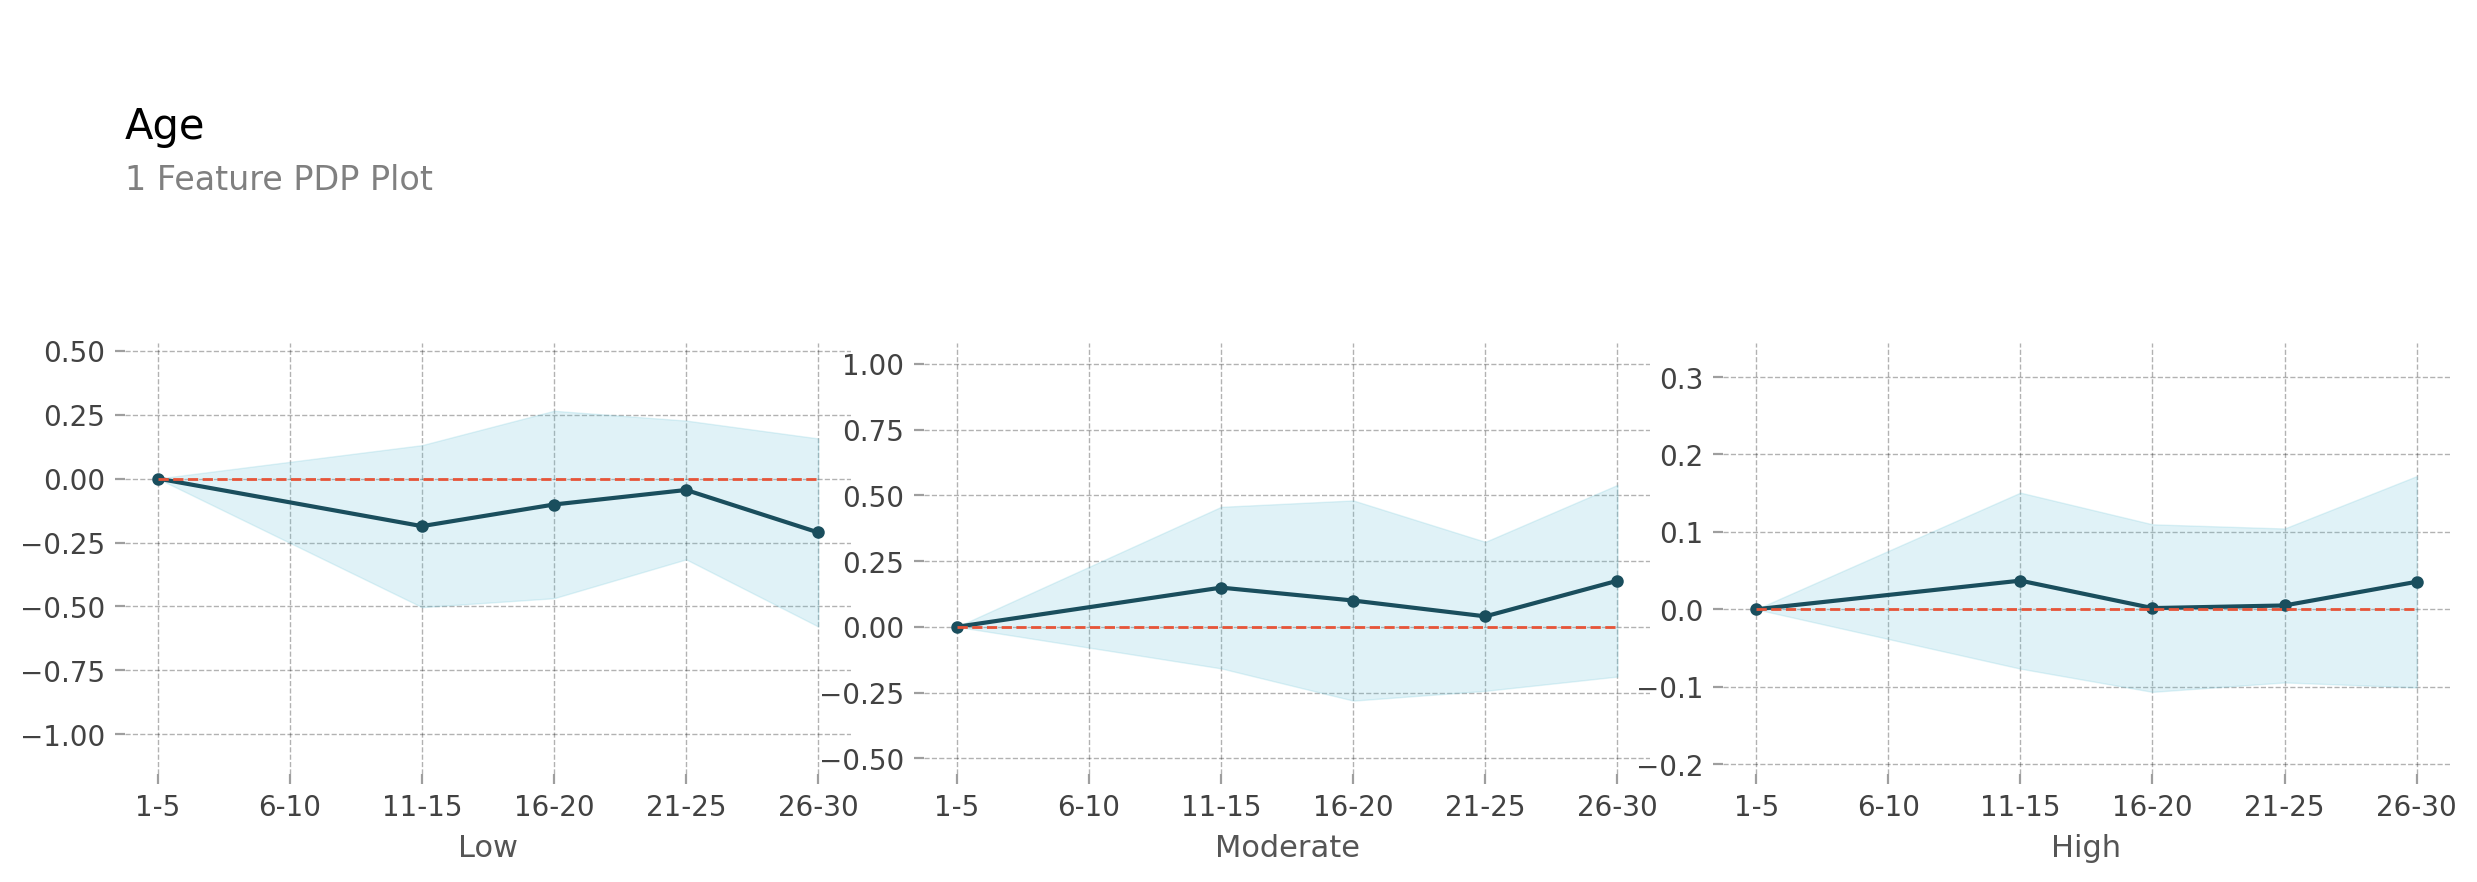

In [57]:
features = pi.index.tolist()[:-5:-1] + ["Age"]
for idx, feature in enumerate(features):
    ticks = list(reverse_mapping[feature].keys())
    labels = list(reverse_mapping[feature].values())
    isolated = pdp_isolate(
        model=optimal_model, 
        dataset=X_test, 
        model_features=X_test.columns, 
        feature=feature,
        num_grid_points=10,
    )
    f, axes = pdp_plot(isolated,
                     feature_name=feature,
                     ncols=3,
                     plot_params = {
                         "title":"%s"%feature,
                         "subtitle":"1 Feature PDP Plot"
                     }
    )
    for class_idx, ax in enumerate(axes["pdp_ax"]):
        ax.set_xticks(ticks=ticks)
        ax.set_xticklabels(labels=labels)
        ax.set_xlabel(target_mapping[class_idx])

### 2-features PDP Interaction

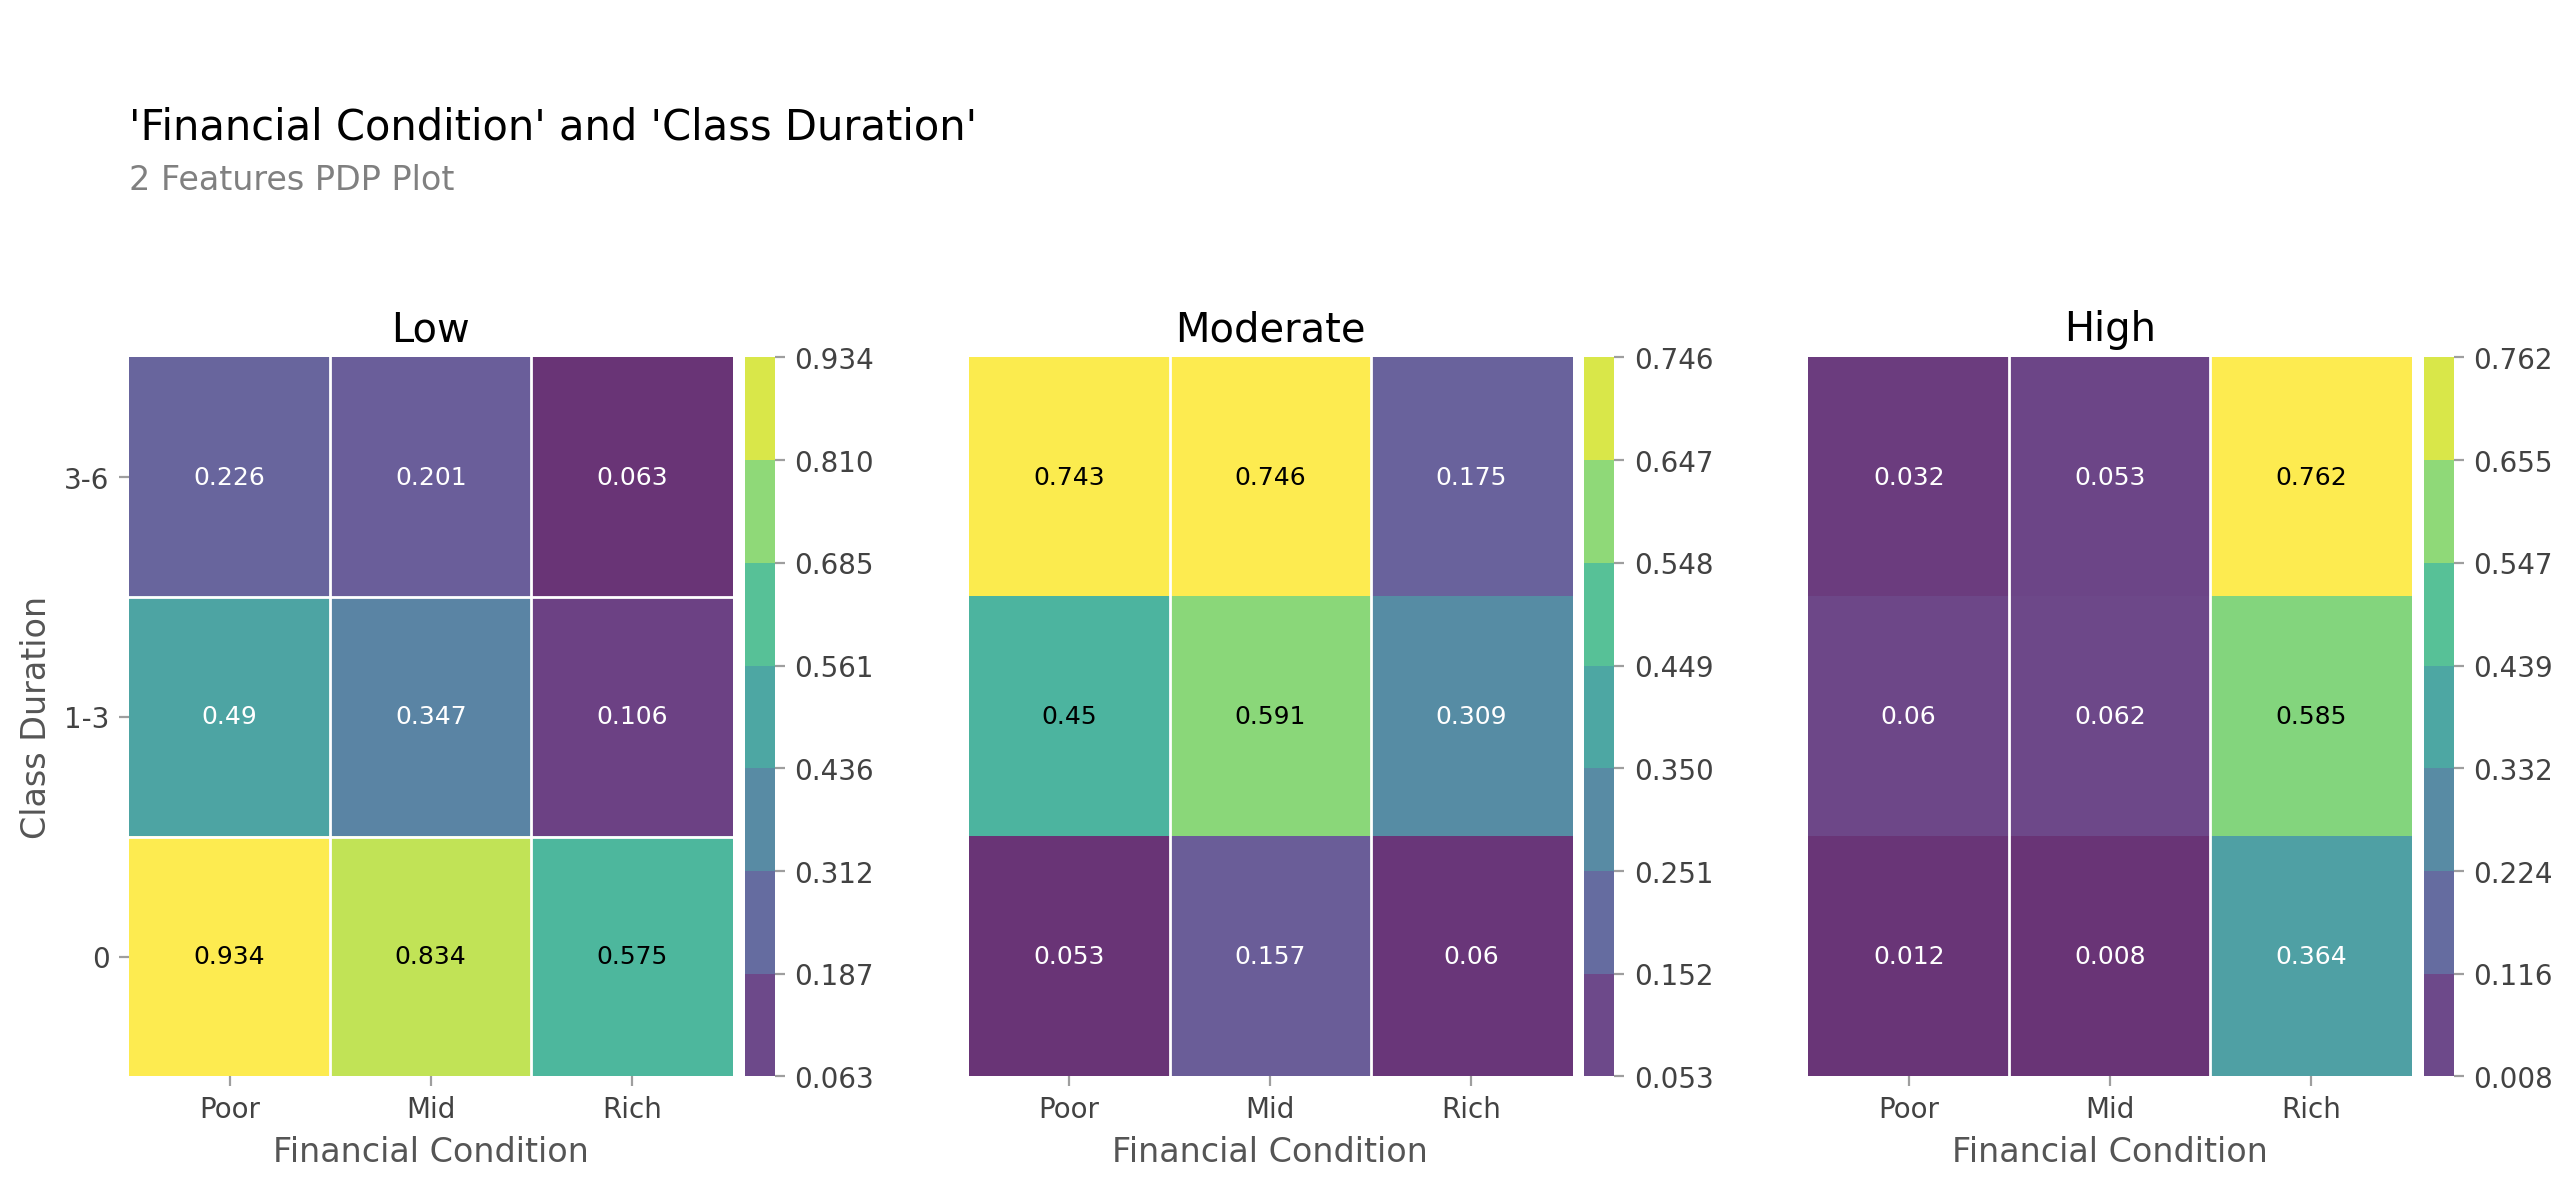

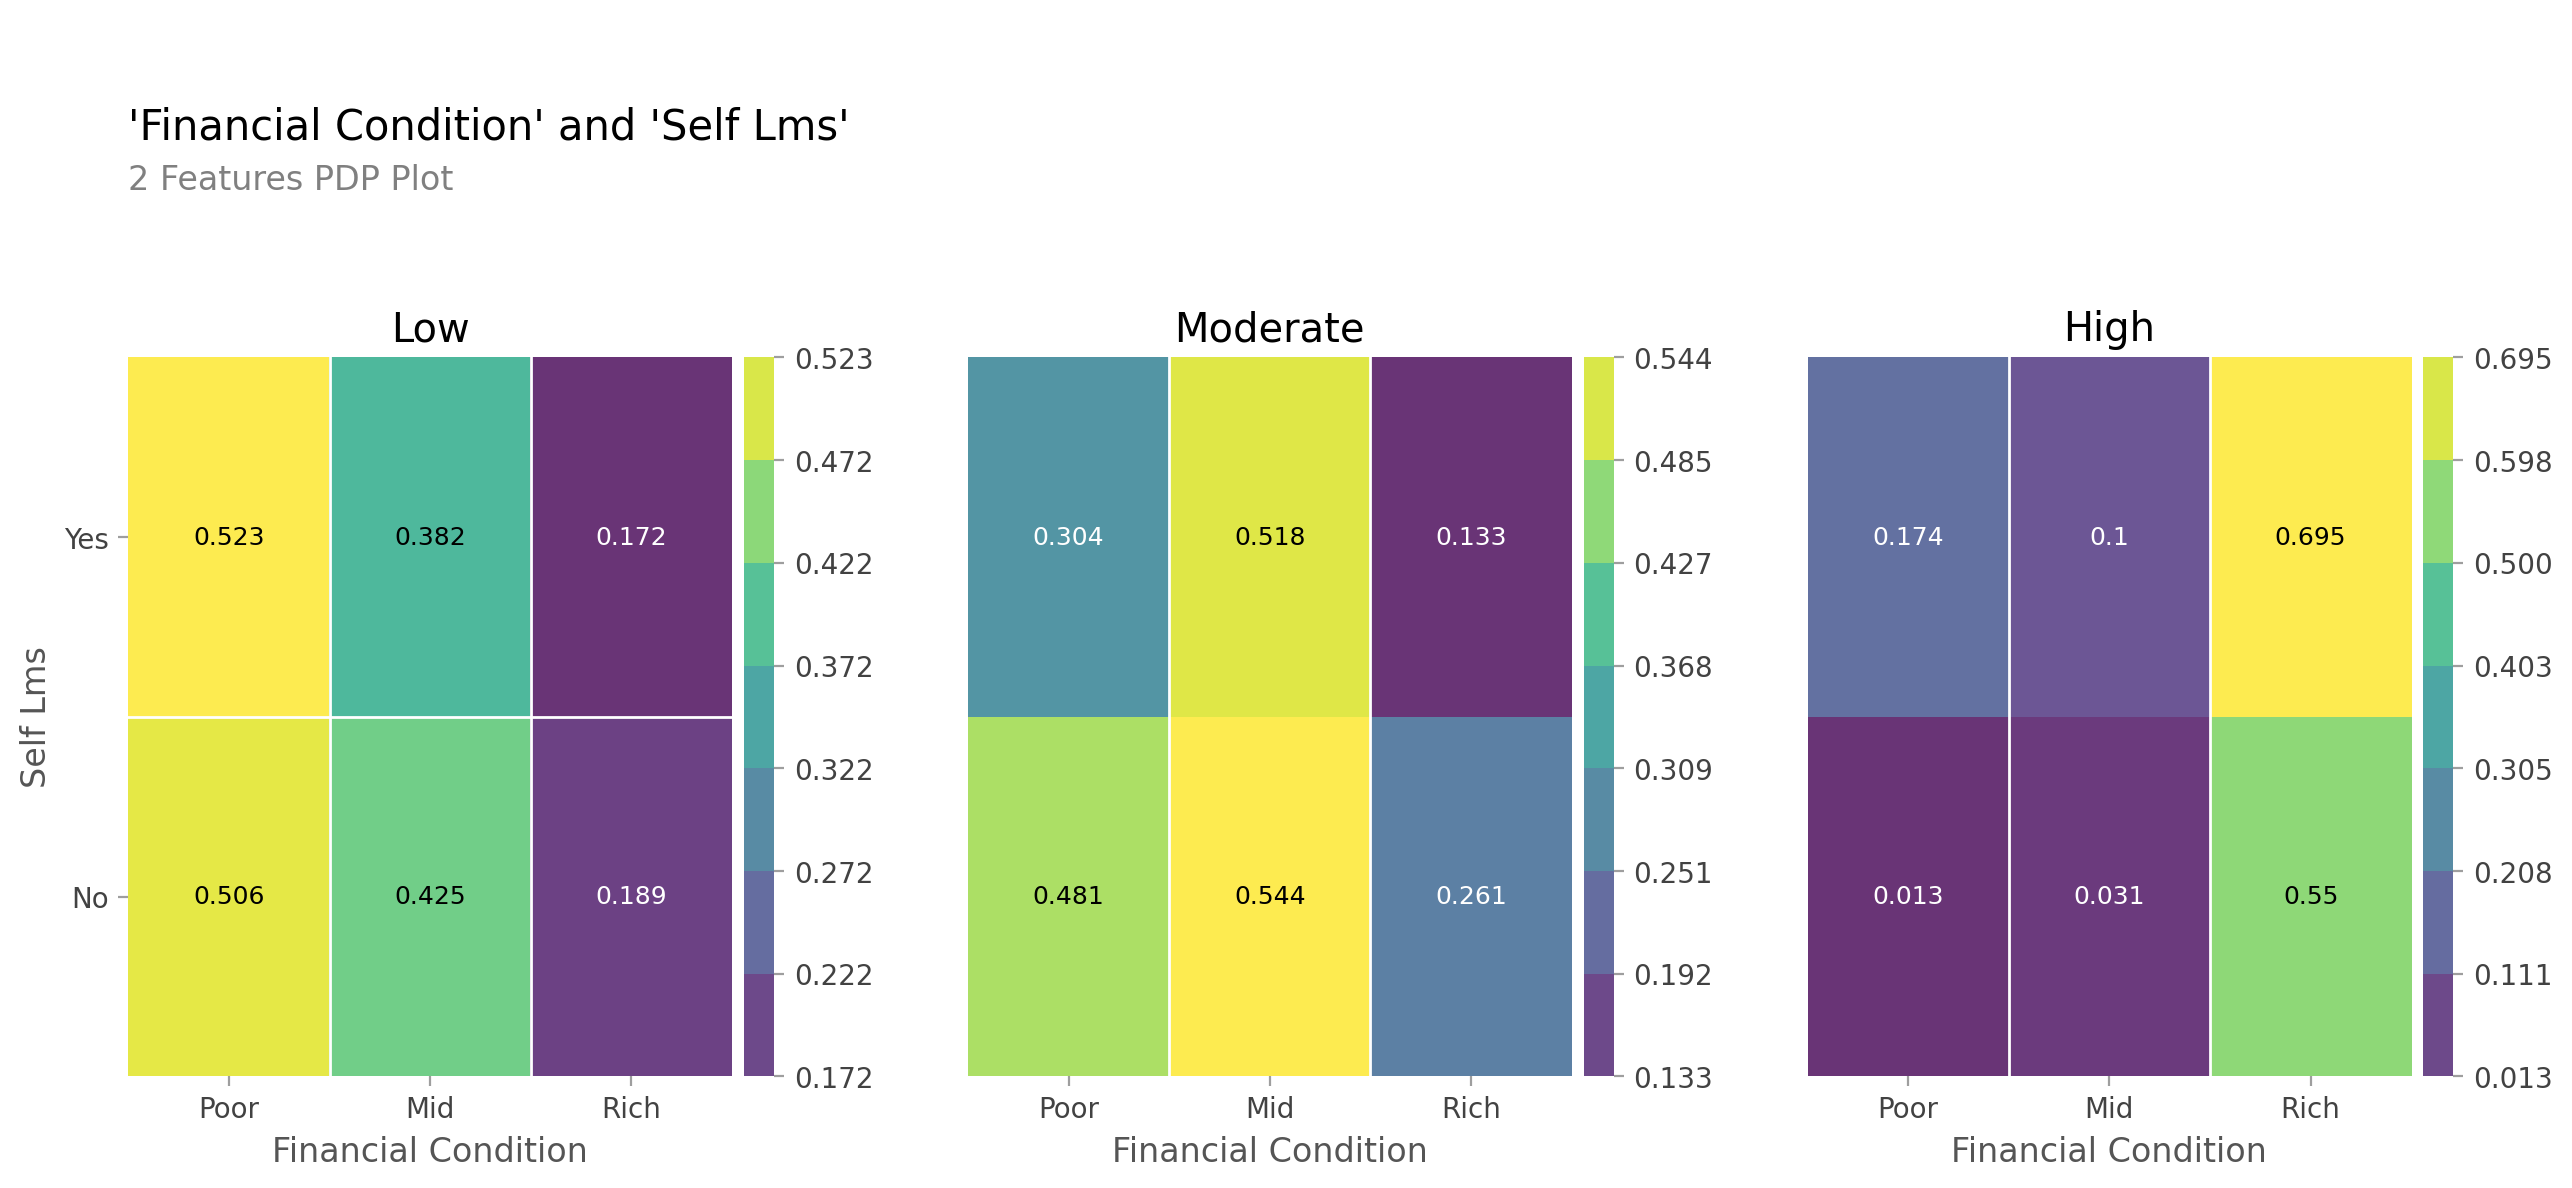

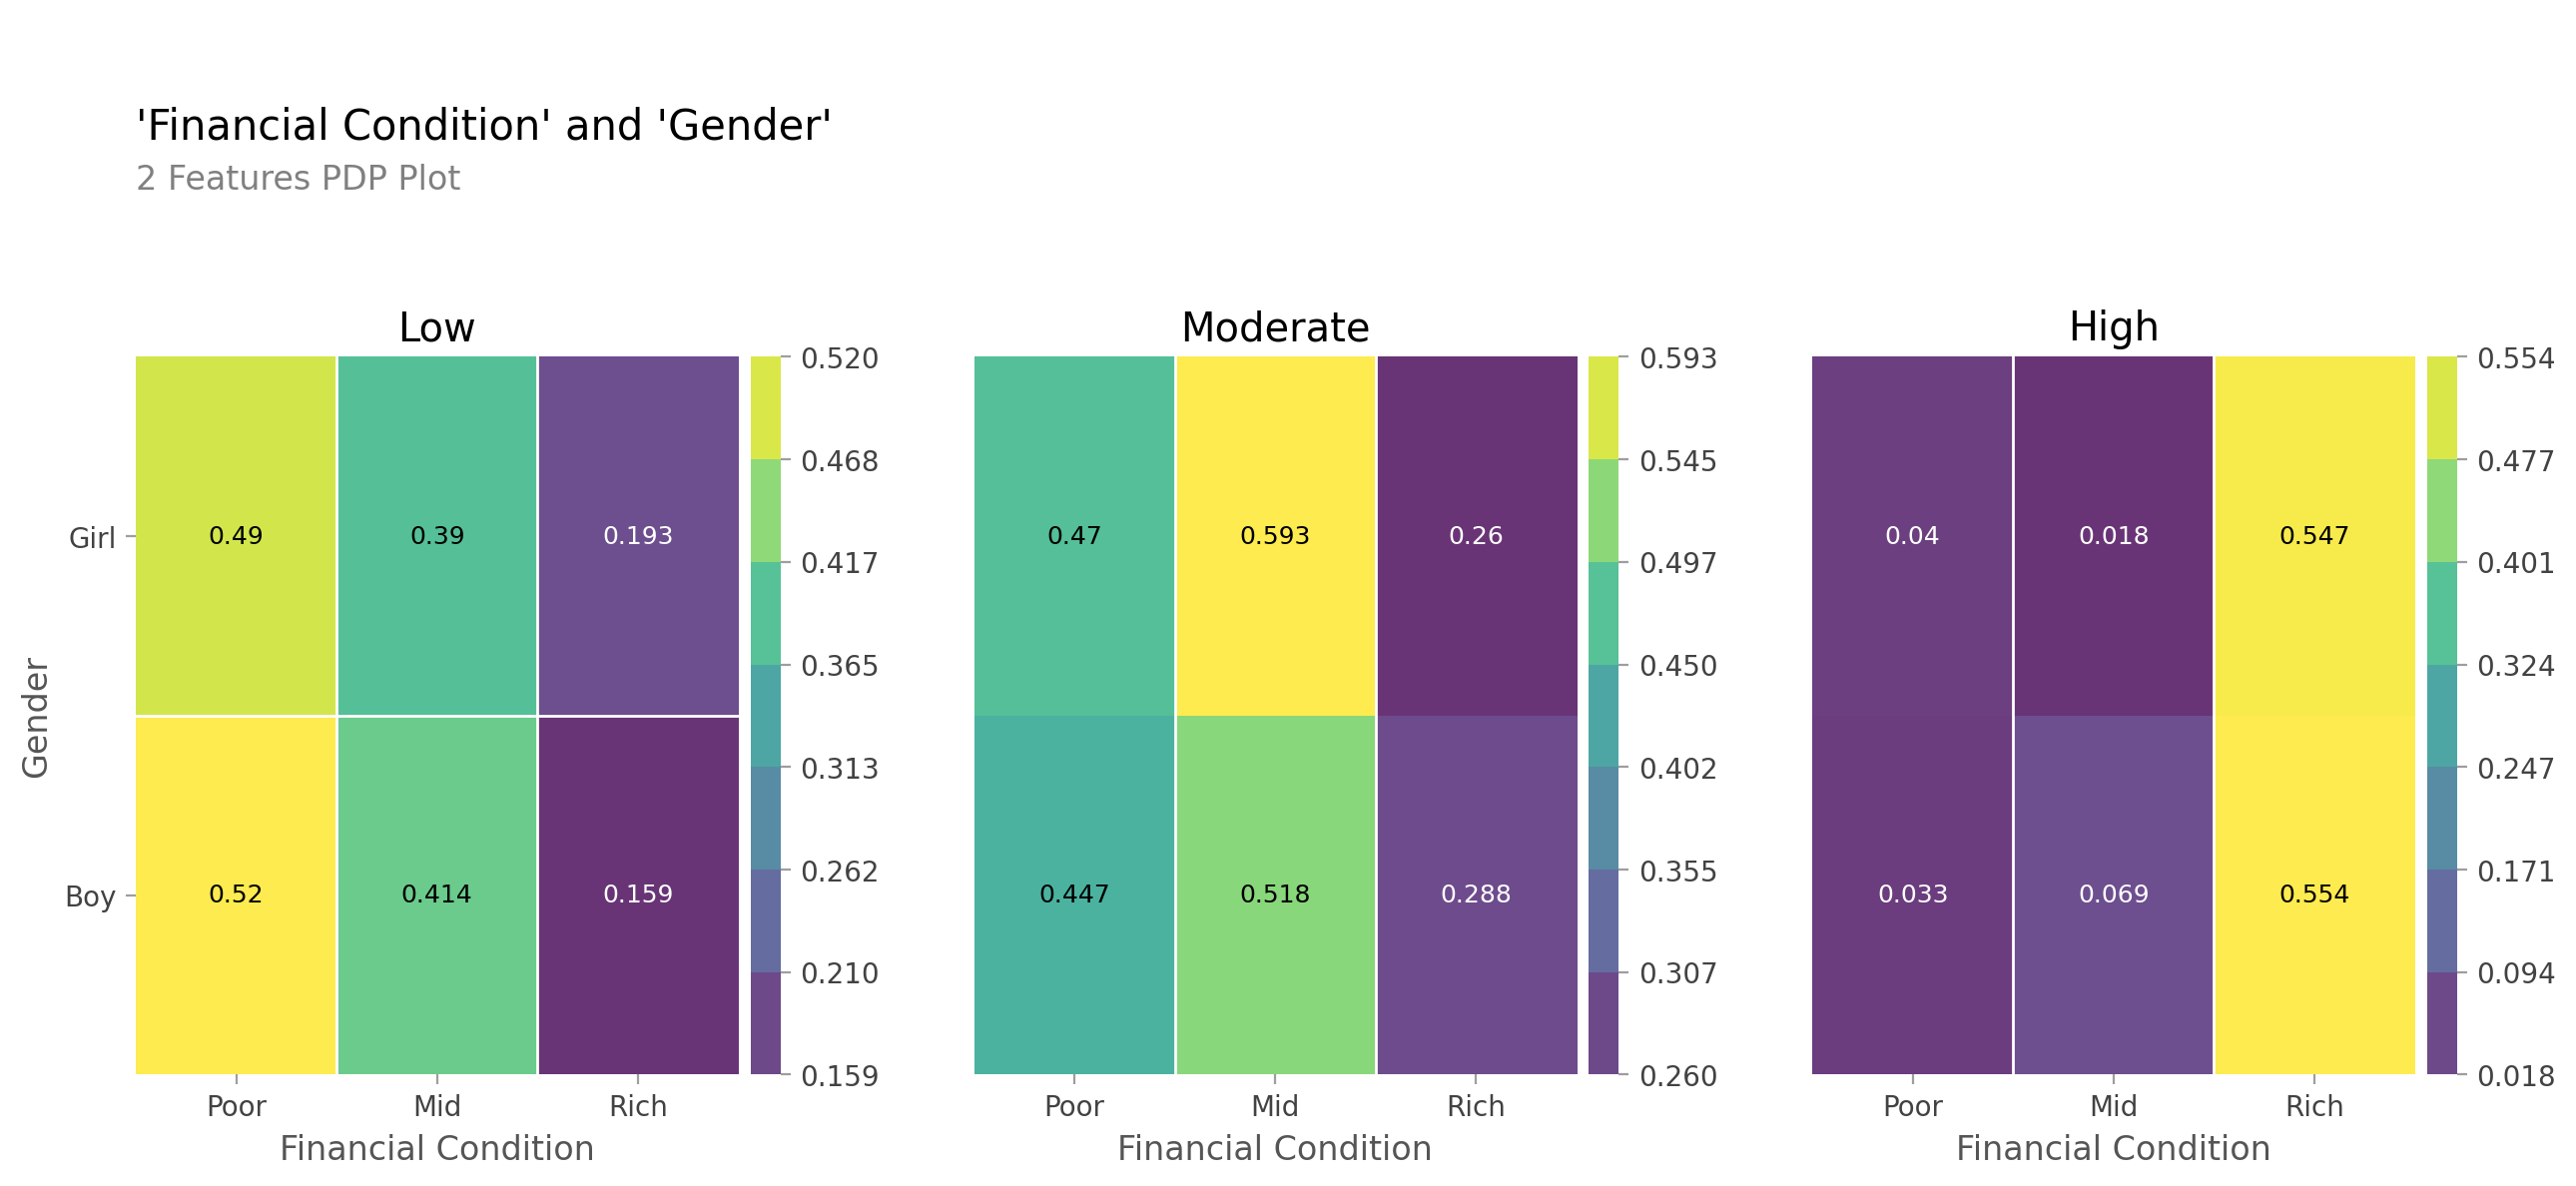

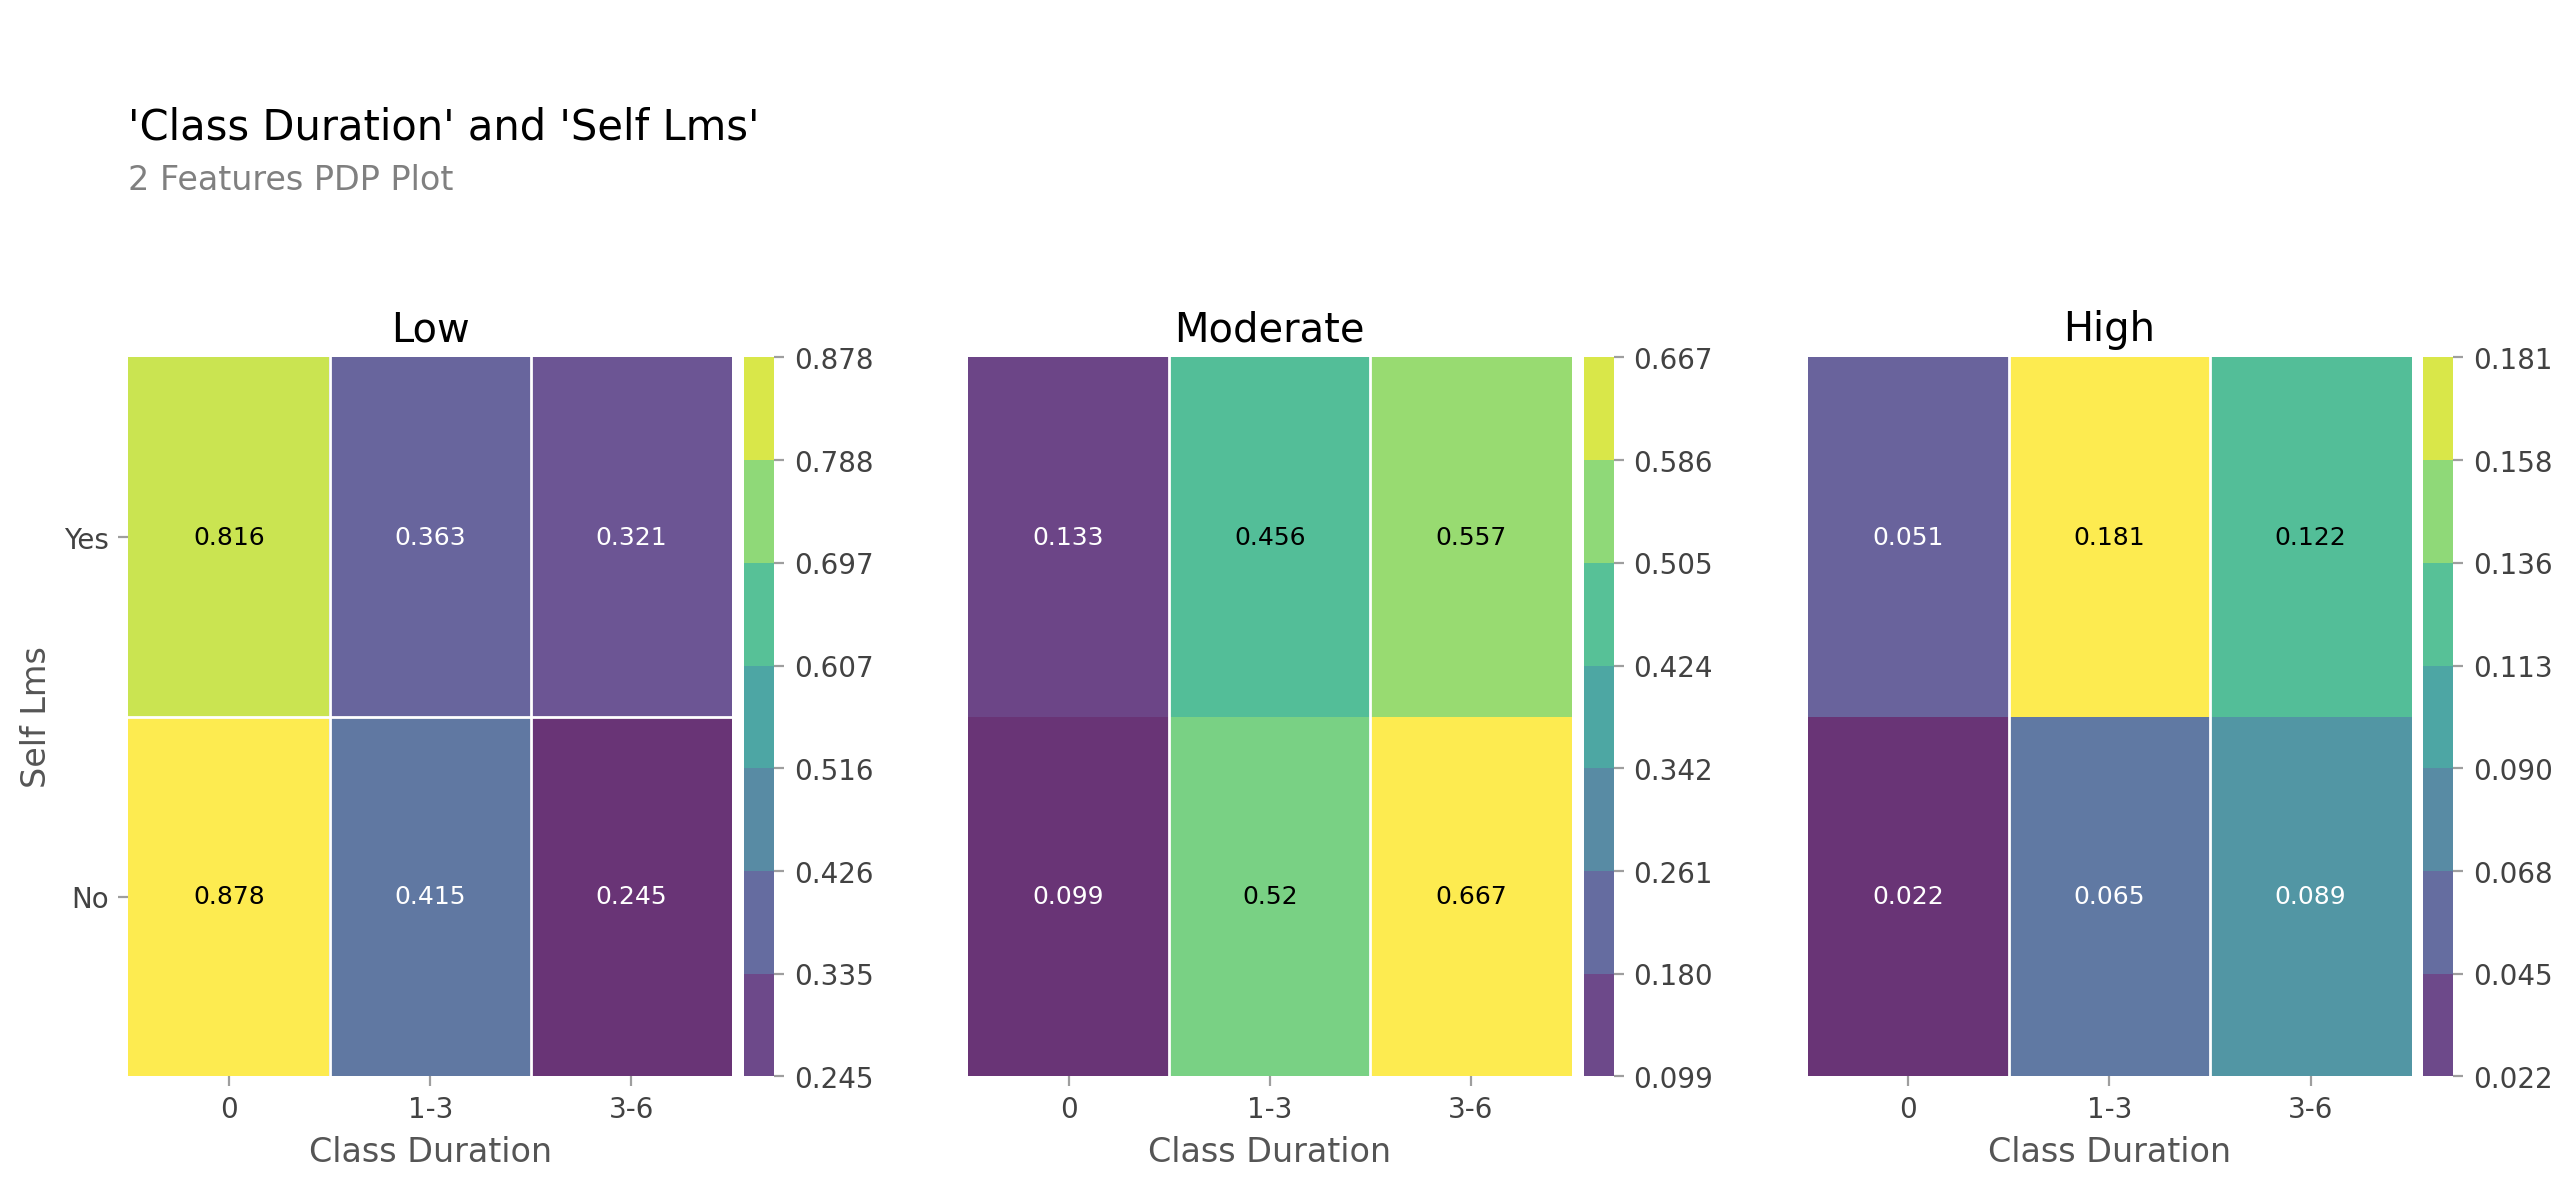

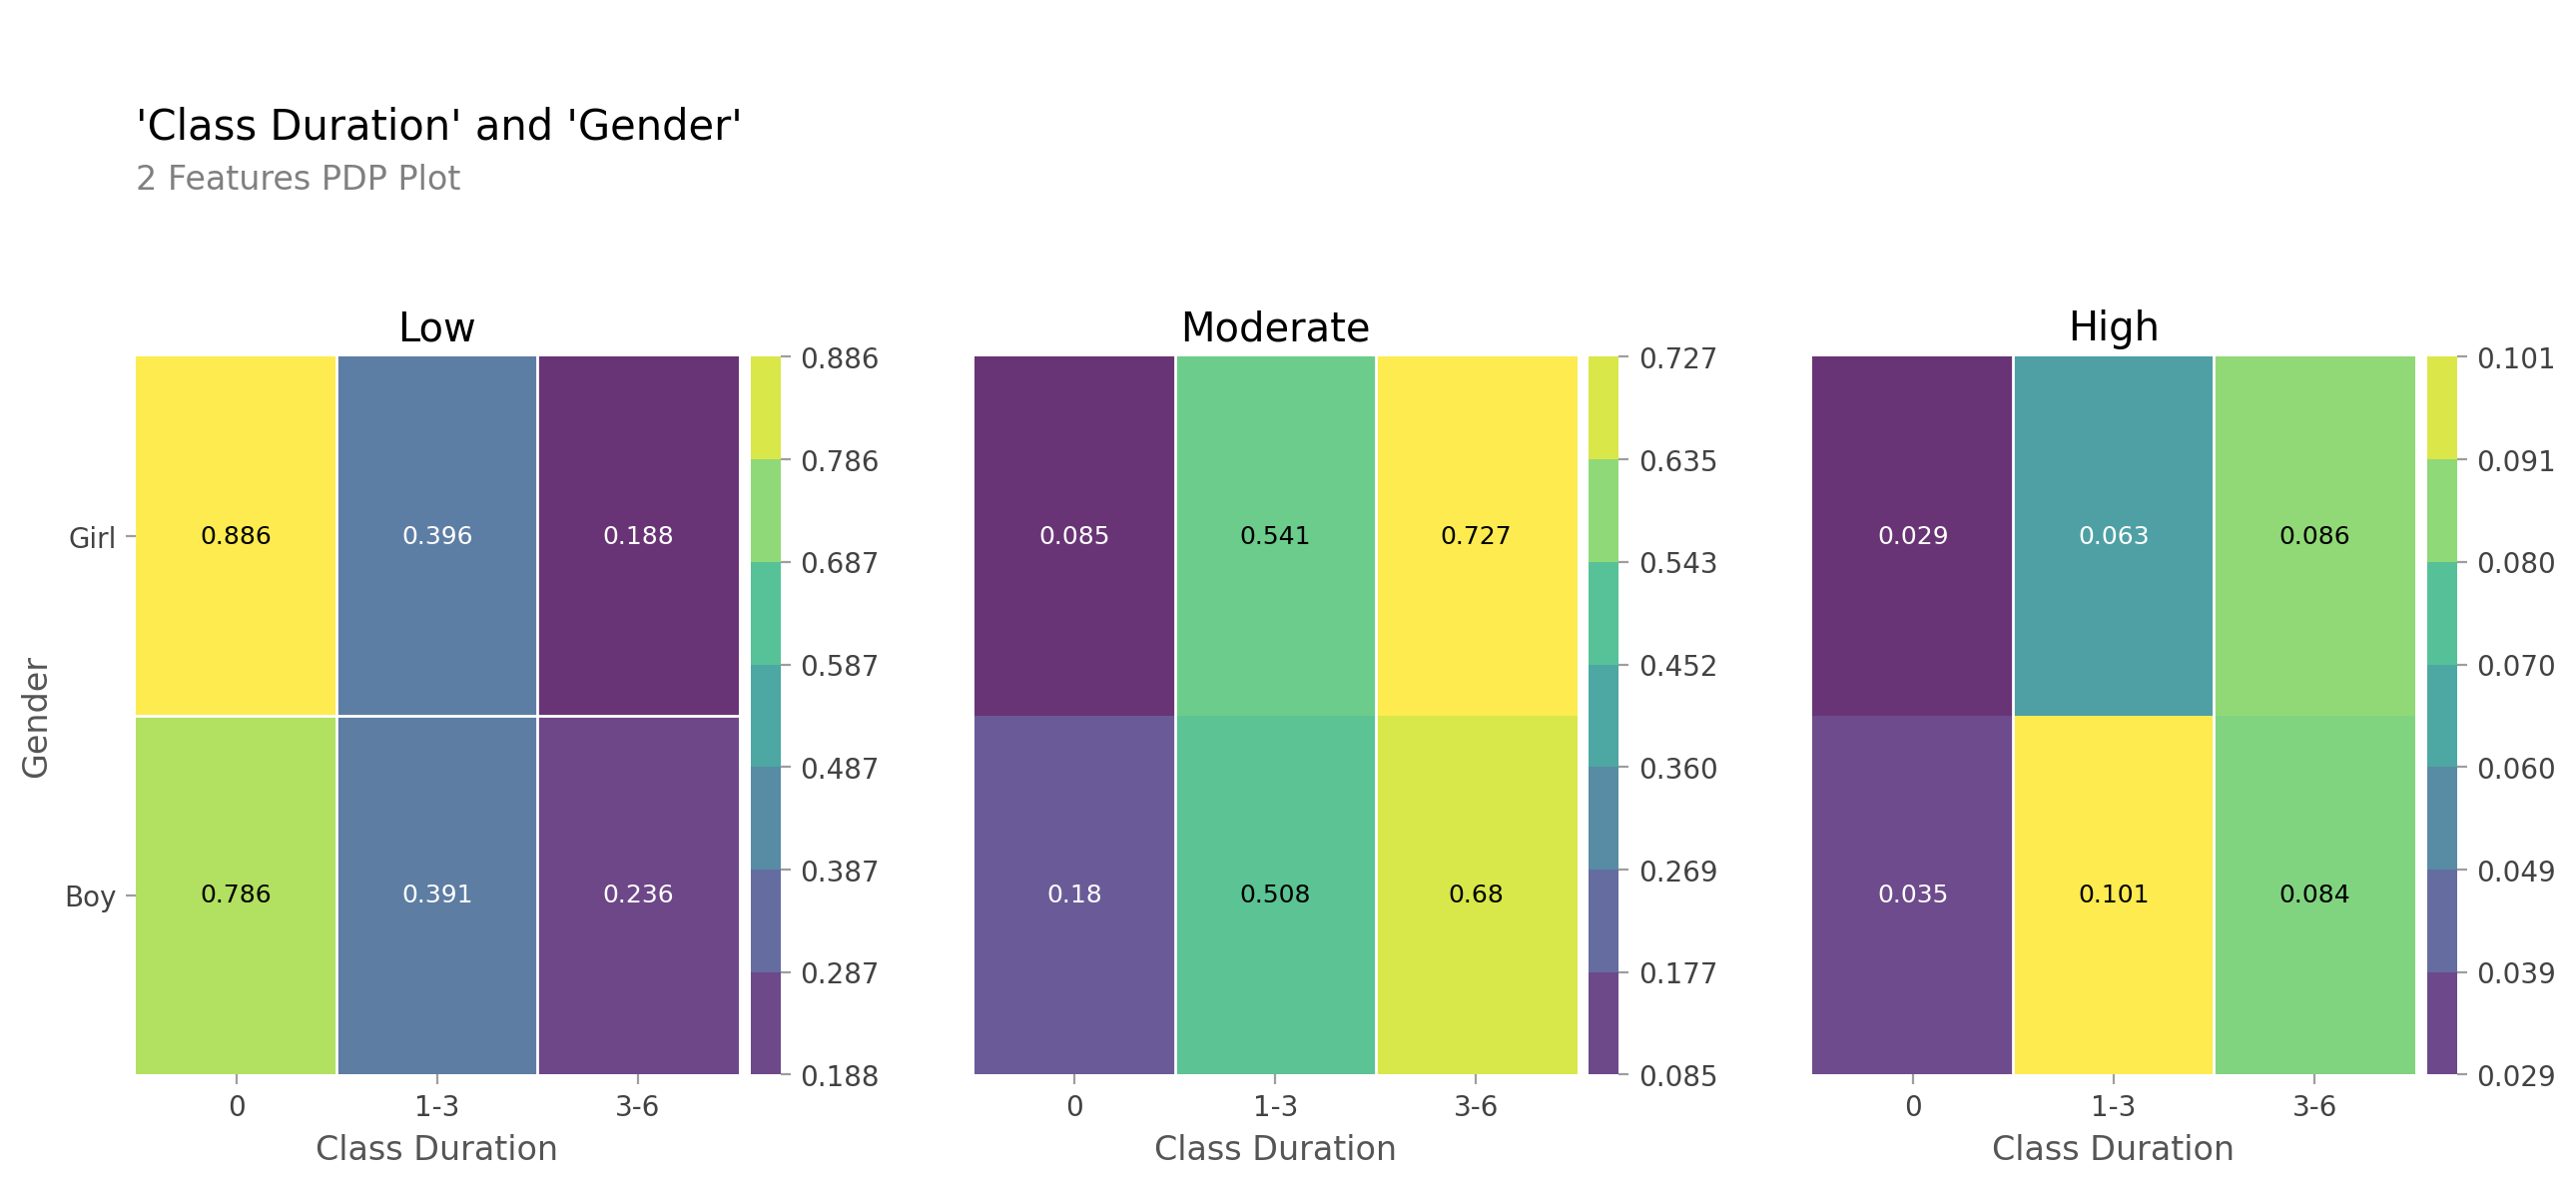

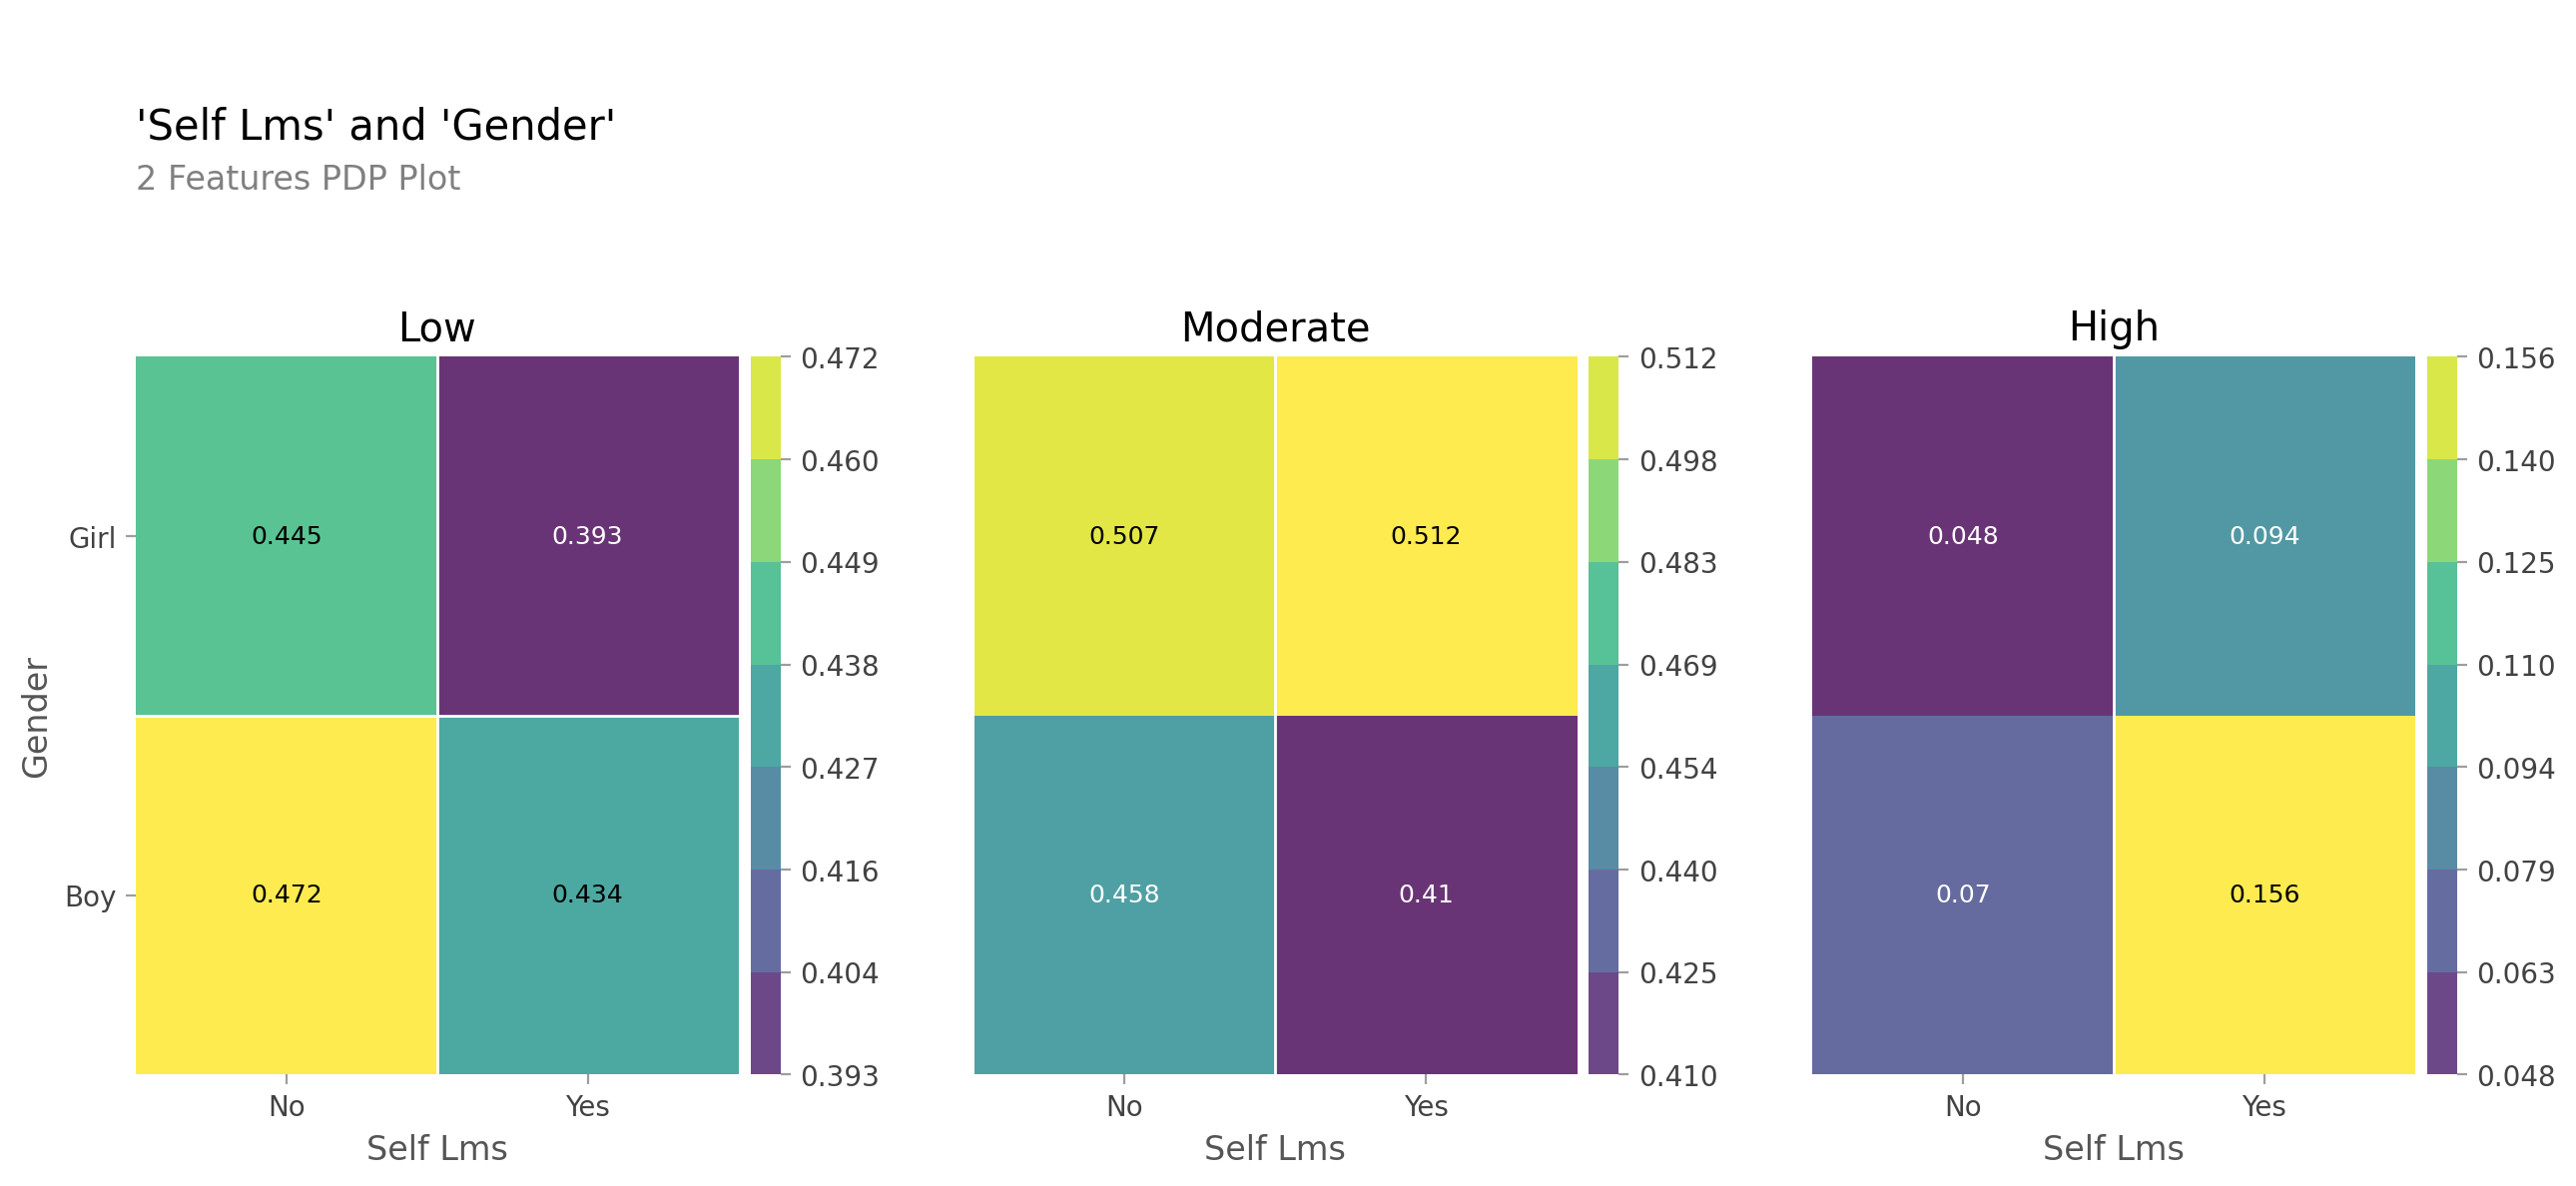

In [58]:
from itertools import combinations, permutations
features.pop()
comb = combinations(features, 2)
for f in comb:
    xticks = list(reverse_mapping[f[0]].keys())
    xlabels = list(reverse_mapping[f[0]].values())
    yticks = list(reverse_mapping[f[1]].keys())
    ylabels = list(reverse_mapping[f[1]].values())
    interact = pdp_interact(
        model = optimal_model,
        dataset=X_test, 
        model_features=X_test.columns, 
        features=f
    )
    fig, axes = pdp_interact_plot(
        pdp_interact_out=interact,
        feature_names=f,
        plot_type='grid',
        ncols=3,
        plot_params={
            "title":"'%s' and '%s'" %f,
            "subtitle":"2 Features PDP Plot",
        }
    )
    for class_idx, ax in enumerate(axes["pdp_inter_ax"]):
        ax.set_xticklabels(labels=xlabels)
        ax.set_xlabel(xlabel=f[0])
        ax.set_yticklabels(labels=ylabels)
        ax.set_title(target_mapping[class_idx])
        ax.grid(False)
        if class_idx > 0:
            ax.set_yticklabels(labels="")
            ax.axes.yaxis.set_visible(False)
    # plt.savefig("2_features_{}_{}_pdp.png".format(f[0], f[1]), dpi=300)

### SHAP - Global Feature Importance (same as MDI)

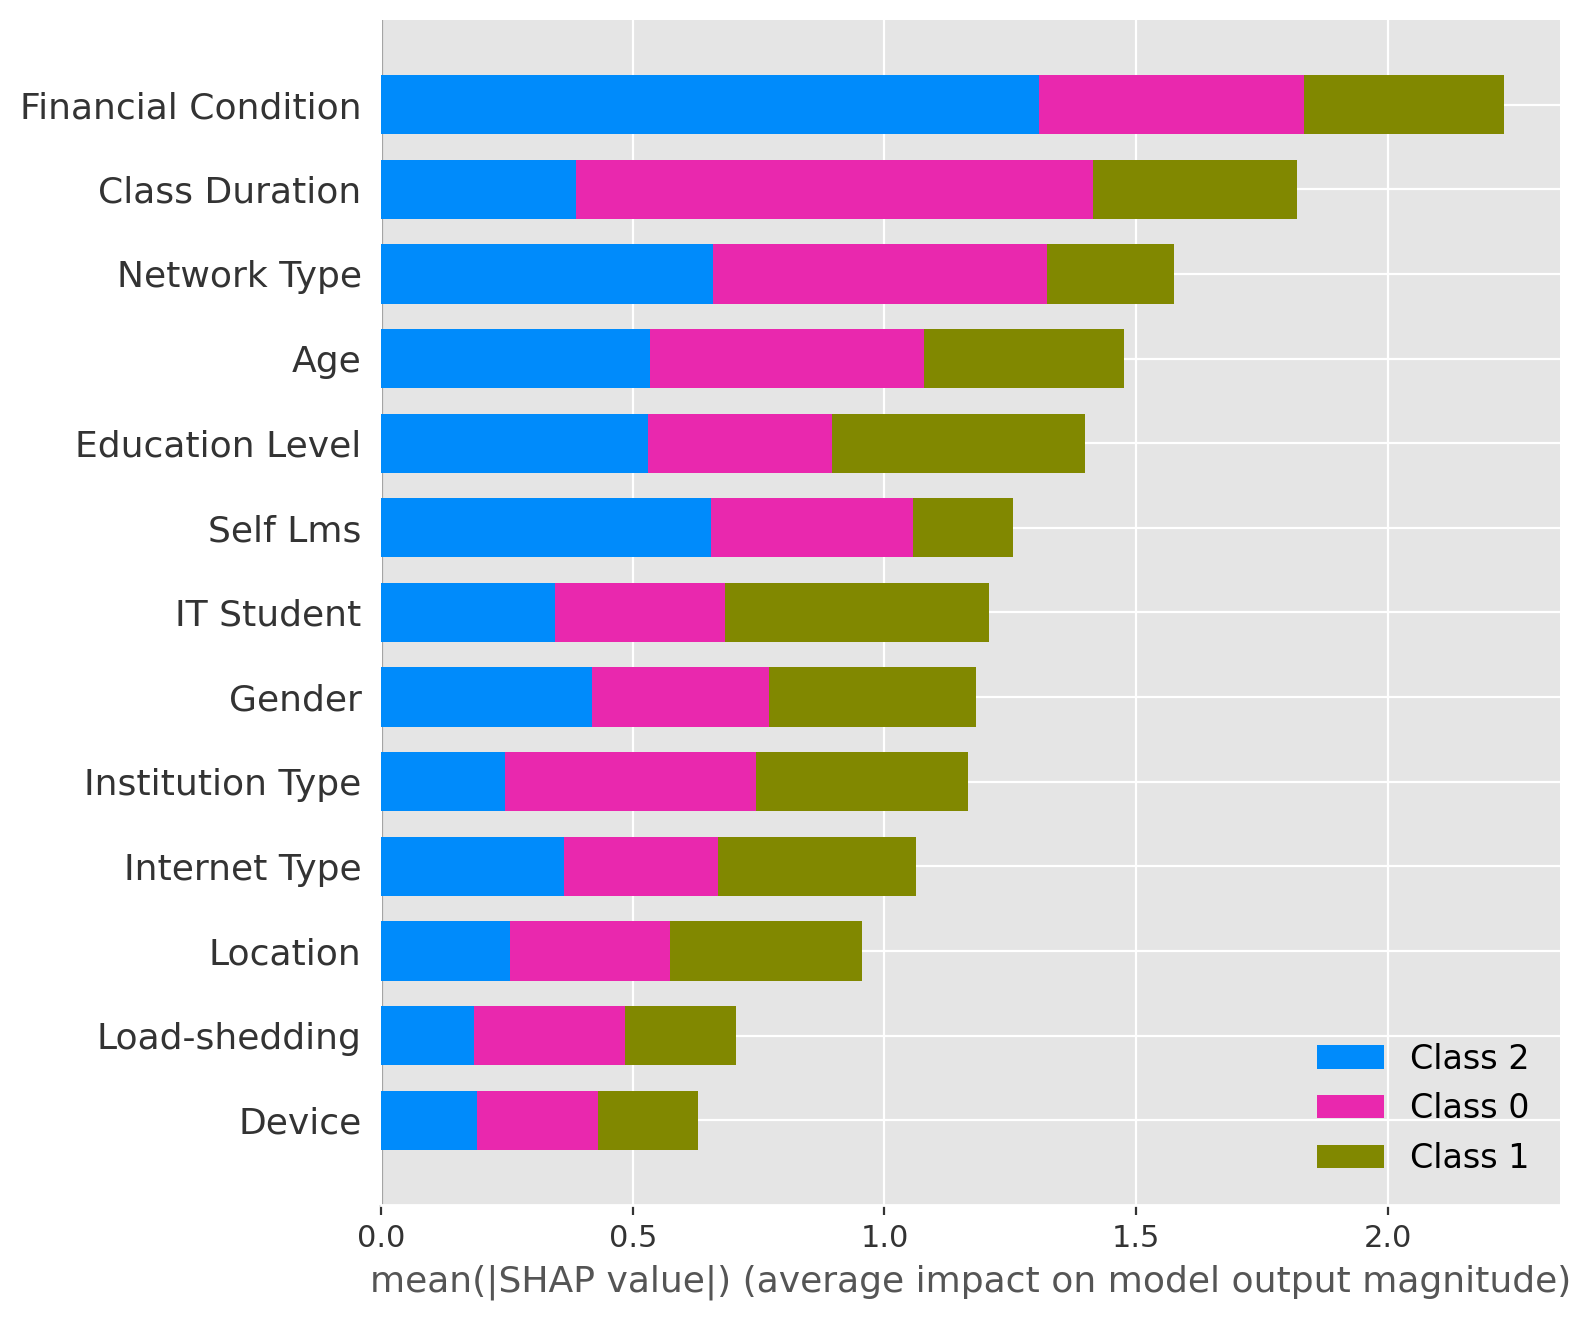

In [59]:
explainer = shap.TreeExplainer(optimal_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(8,6.5))
shap.summary_plot(shap_values, X_test)
# plt.savefig("feature_importance_shap.png", dpi=300)

In [60]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0],
    features=X_test
)

In [61]:
plt.rcParams.update(plt.rcParamsDefault)

### SHAP prediction for one sample

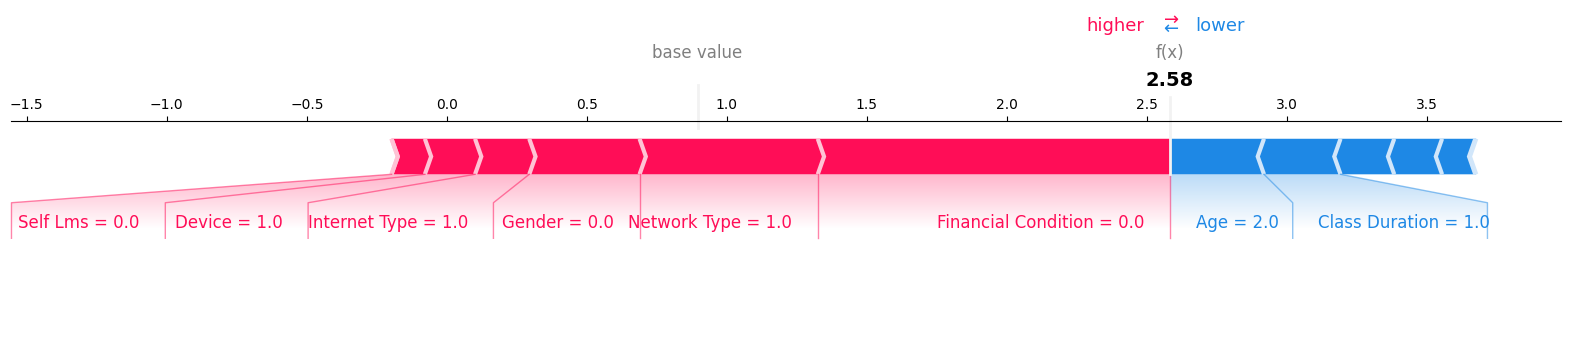

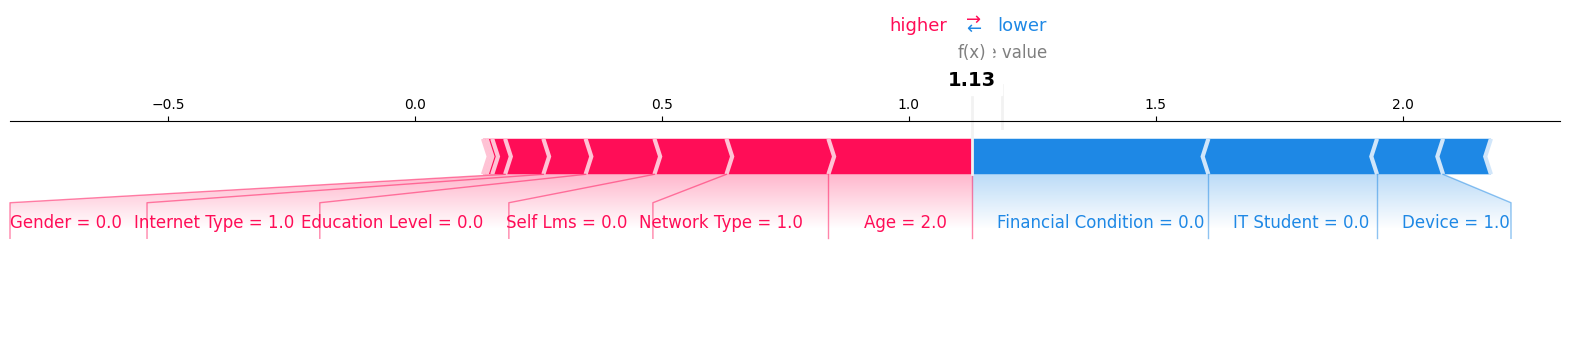

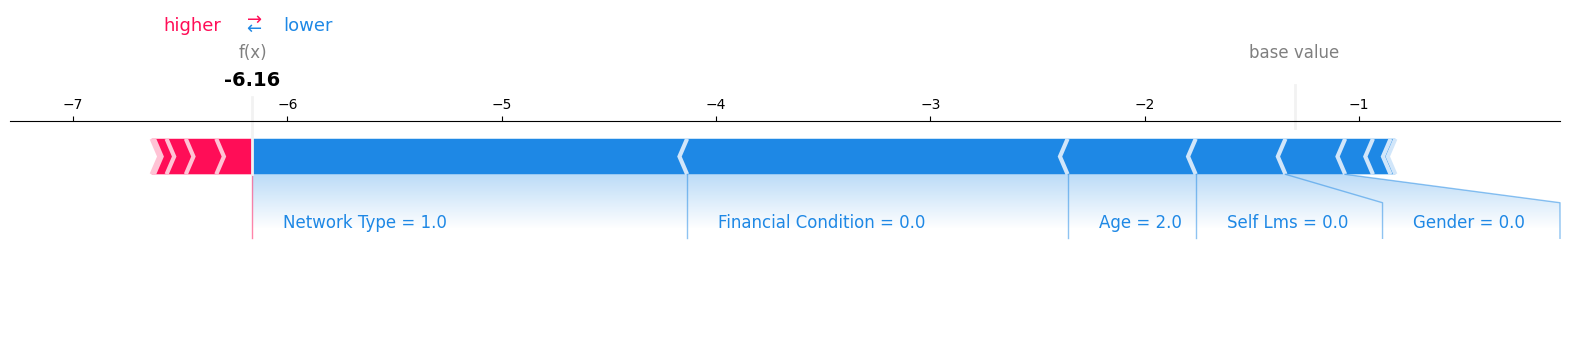

In [62]:
sample1 = X_test.sample(random_state=2342)

shap_values_sample1 = explainer.shap_values(sample1)
for i in range(n_classes):
    shap.force_plot(
        base_value=explainer.expected_value[i], 
        shap_values=shap_values_sample1[i],
        features=sample1,
        matplotlib=True
    )

### Information of sample

In [63]:
s1 = sample1.iloc[0]
s1_idx = s1.index.tolist()
for idx, value in enumerate(s1):
    print(s1_idx[idx], ":", reverse_mapping[s1_idx[idx]][value])

Gender : Boy
Age : 11-15
Education Level : School
Institution Type : Non Government
IT Student : No
Location : Yes
Load-shedding : Low
Financial Condition : Poor
Internet Type : Mobile Data
Network Type : 3G
Class Duration : 1-3
Self Lms : No
Device : Mobile


In [64]:
optimal_model.predict(sample1) # predicted class

array([0])

In [65]:
y_test.loc[sample1.index[0]] # real class

0

### Change Network Type to 4G

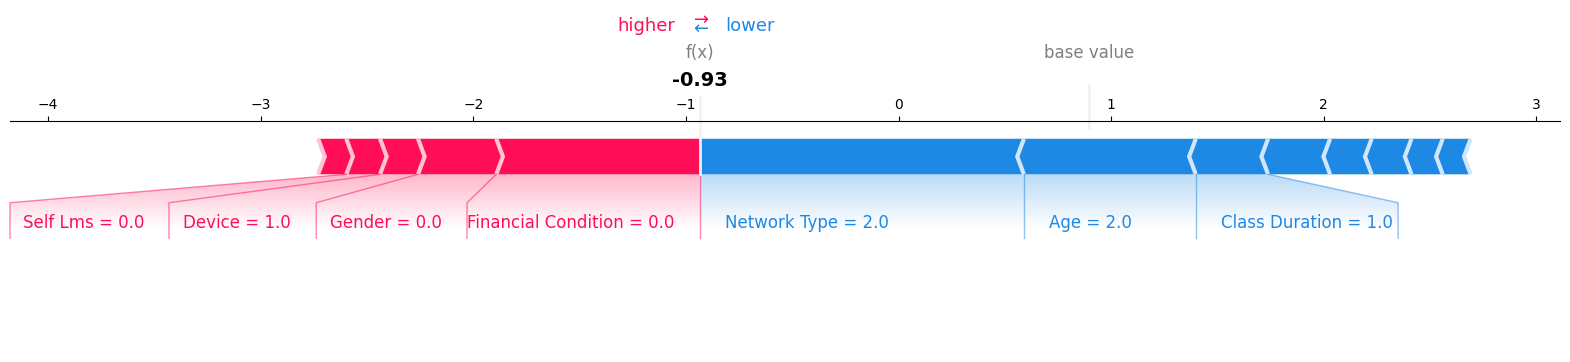

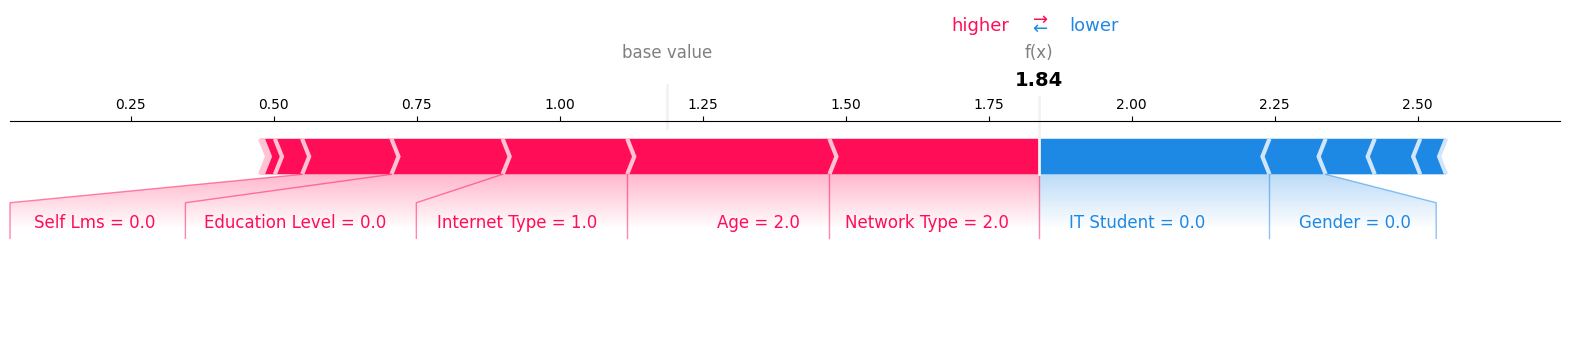

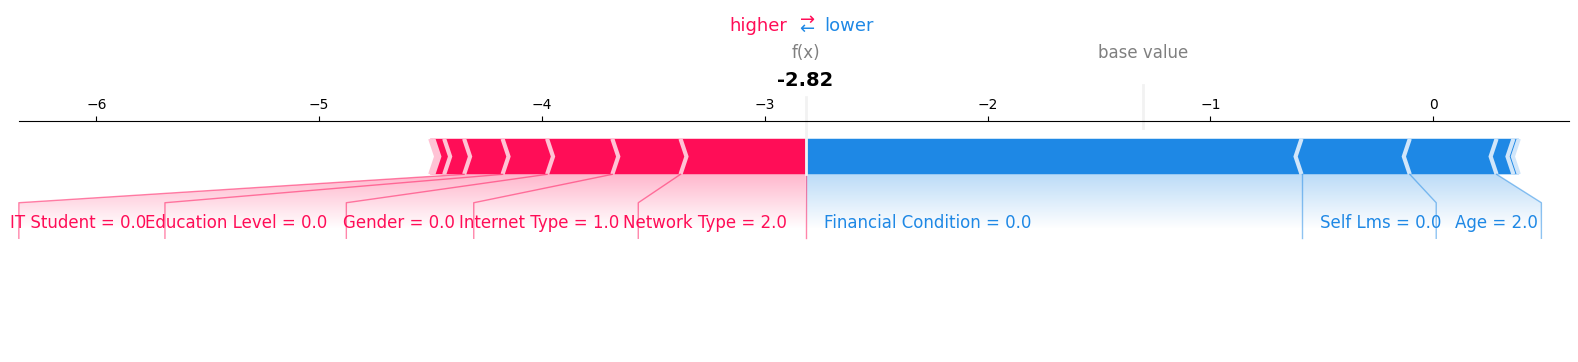

In [66]:
sample2 = sample1.copy()
sample2["Network Type"] = 2
shap_values_sample1 = explainer.shap_values(sample2)
for i in range(n_classes):
    shap.force_plot(
        base_value=explainer.expected_value[i], 
        shap_values=shap_values_sample1[i],
        features=sample2,
        matplotlib=True
    )

In [67]:
optimal_model.predict(sample2) # predicted class

array([1])

### Change Self Lms to Yes

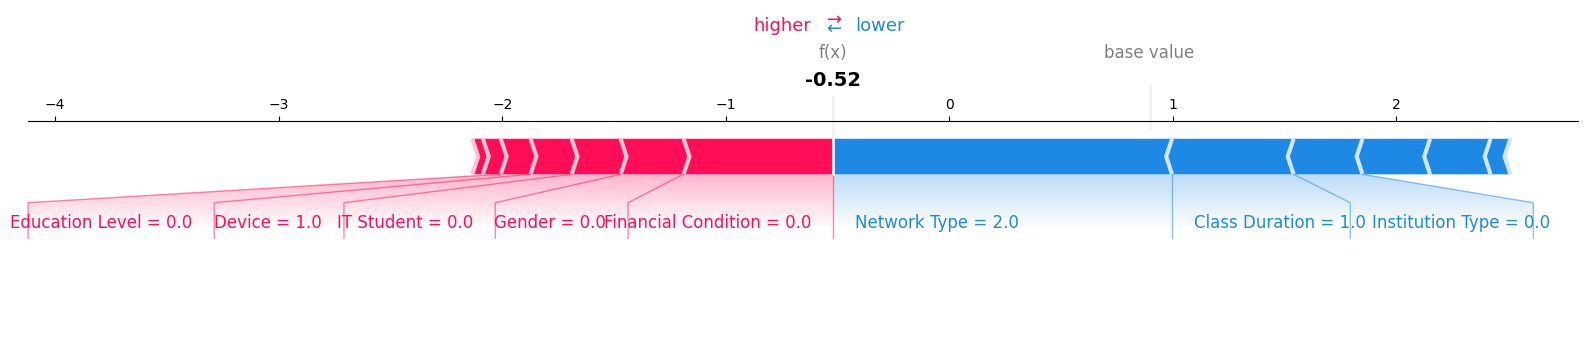

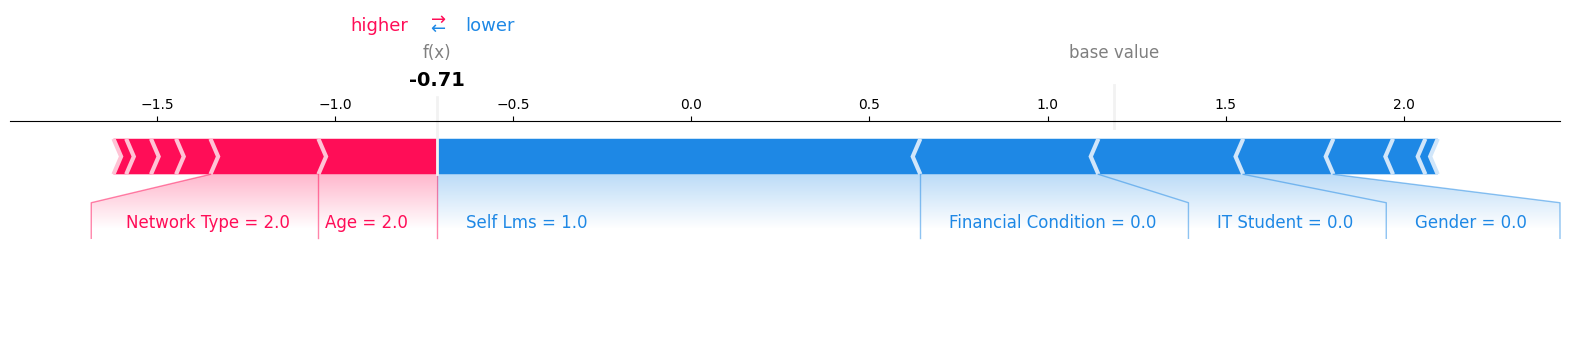

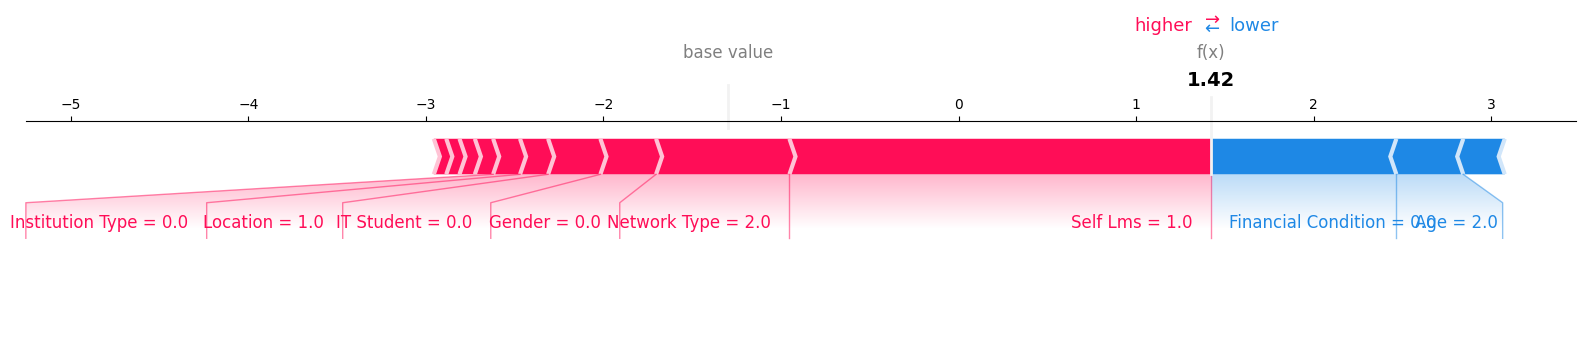

In [68]:
sample2["Self Lms"] = 1
shap_values_sample1 = explainer.shap_values(sample2)
for i in range(n_classes):
    shap.force_plot(
        base_value=explainer.expected_value[i], 
        shap_values=shap_values_sample1[i],
        features=sample2,
        matplotlib=True
    )

In [69]:
optimal_model.predict(sample2) # predicted class

array([2])